In [2]:
%matplotlib inline


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import xbout
import scipy
import xhermes

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *

import gridtools.solps_python_scripts.setup
from gridtools.solps_python_scripts.utilities.last10s       import read_last10s

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.solps_pp import *
from code_comparison.viewer_2d import *


%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Done


In [3]:
db = CaseDB()

toload = [ 
    dict(name="base_noAFN", id="hn2d1cc-noAFN_base_widev2", unnormalise_geom = True, use_xhermes = True, squash = True), 
    dict(name="base_AFN", id="hn2d1h-AFN_base_widev2", unnormalise_geom = True, use_xhermes = True, squash = True), 
    dict(name="base_AFN_nocondlim", id="hn2d1i-AFN_nocondlim_widev2", unnormalise_geom = True, use_xhermes = True, squash = True), 
    dict(name="hotneut", id="hn4c-hnthresh_0_widev2", unnormalise_geom = True, use_xhermes = True, squash = True), 
    dict(name="hotneut_AFN", id="hn4d-hnthresh_0_widev2_AFN", unnormalise_geom = True, use_xhermes = True, squash = True), 
    # dict(name="hotneut_AFN", id="hn4d-hnthresh_0_widev2_AFN", unnormalise_geom = True, use_xhermes = True, squash = True), 
    # dict(name="hotneut_AFN_nopump", id="hn4e-hnthresh_0_widev2_AFN_nopump", unnormalise_geom = True, use_xhermes = True, squash = True), 
]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = case["squash"], verbose = True)


- Reading case hn2d1cc-noAFN_base_widev2
-----------------------
- Looking for squash file
- Squash file found. squash date 04/23/2024, 11:53:10, dmp file date 04/22/2024, 21:08:33


C:\Users\mikek\OneDrive\Project\python-packages\xBOUT\xbout\load.py:1138: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes
- Reading case hn2d1h-AFN_base_widev2
-----------------------
- Looking for squash file
- Squash file found. squash date 04/23/2024, 11:57:00, dmp file date 04/23/2024, 10:47:36


C:\Users\mikek\OneDrive\Project\python-packages\xBOUT\xbout\load.py:1138: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes
- Reading case hn2d1i-AFN_nocondlim_widev2
-----------------------
- Looking for squash file
- Squash file found. squash date 04/22/2024, 16:10:51, dmp file date 04/22/2024, 15:44:58


C:\Users\mikek\OneDrive\Project\python-packages\xBOUT\xbout\load.py:1138: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes
- Reading case hn4c-hnthresh_0_widev2
-----------------------
- Looking for squash file
- Squash file found. squash date 04/22/2024, 19:34:23, dmp file date 04/20/2024, 17:23:38


C:\Users\mikek\OneDrive\Project\python-packages\xBOUT\xbout\load.py:1138: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes
- Reading case hn4d-hnthresh_0_widev2_AFN
-----------------------
- Looking for squash file
- Squash file found. squash date 04/22/2024, 19:35:30, dmp file date 04/22/2024, 19:26:04


C:\Users\mikek\OneDrive\Project\python-packages\xBOUT\xbout\load.py:1138: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes


# Read SOLEDGE

In [4]:
soledgecases = {
    "tightwall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_1e19"), # Hermes-3 like wall
    "tightwall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_2e19"), # Hermes-3 like wall
    "widewall_2e19_5m" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19_5M"),
    "tightwall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_3e19"), # Hermes-3 like wall
    "widewall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_1e19"), 
    "widewall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19"), 
    "widewall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_3e19"), 
}

sl = dict()

for name in soledgecases:
    path = soledgecases[name]
    sl[name] = SOLEDGEdata(path = path)
    sl[name].read_csv(os.path.join(path, "omp_plasma.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "omp_neutrals.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "imp_plasma.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "imp_neutrals.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")



c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astyp

# Read SOLPS

In [5]:
solpscases = {
    # "base" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5"),
    "noiz_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16"),
    # "gammai_2.5" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00"),
    # "dpuff_1e22" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22"),
    # "dpuff_5e21" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=5.0E+21"),
    # "no_fast_reflec" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.Pf=0"),
    # "nsep_2e19" : os.path.join(onedrive_path,r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=2E+19"),
    # "nsep_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=3E+19"),
    # "narrow_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent"),
    # "no_visc" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent.b2tqca_phm0=0"),
    # "16x_mc" : os.path.join(onedrive_path, r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.xxx.BCCON=16.core_extent.MC.histories.x16-ish.NOT.converged"),
    "tightwall_2e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19",
    "tightwall_noD2_1e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=1.0E+19.NO.D2",
    "tightwall_noD2_2e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19.NO.D2",
    "tightwall_noD2_3e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=3.0E+19.NO.D2",
    
}

sp = dict()

for name in solpscases:
    sp[name] = SOLPSdata()
    # sp[name].read_last10s(solpscases[name])
    sp[name].read_from_case(solpscases[name])

# Read Hermes-3

In [7]:
cs.keys()

dict_keys(['base_noAFN', 'base_AFN', 'base_AFN_nocondlim', 'hotneut', 'hotneut_AFN', 'hotneut_AFN_nopump'])

In [6]:
hr = dict()
for name in cs.keys(): 
    print(name)
    hr[name] = Hermesdata()
    hr[name].read_case(cs[name].ds.isel(t=-1))

    
    ds = cs[name].ds
    ds = calculate_radial_fluxes(ds, new_afn = True)
    # ds = calculate_target_fluxes(ds)
    ds = reverse_pfr_fluxes(ds)

base_noAFN
base_AFN
base_AFN_nocondlim
hotneut
hotneut_AFN


# Convergence

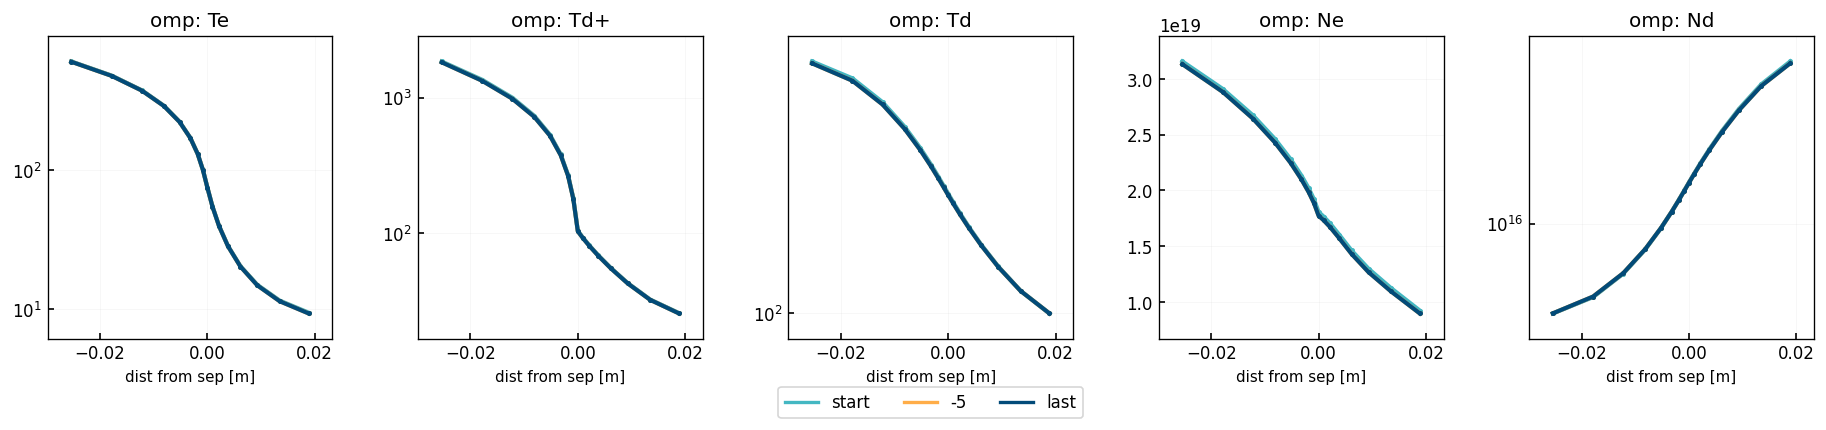

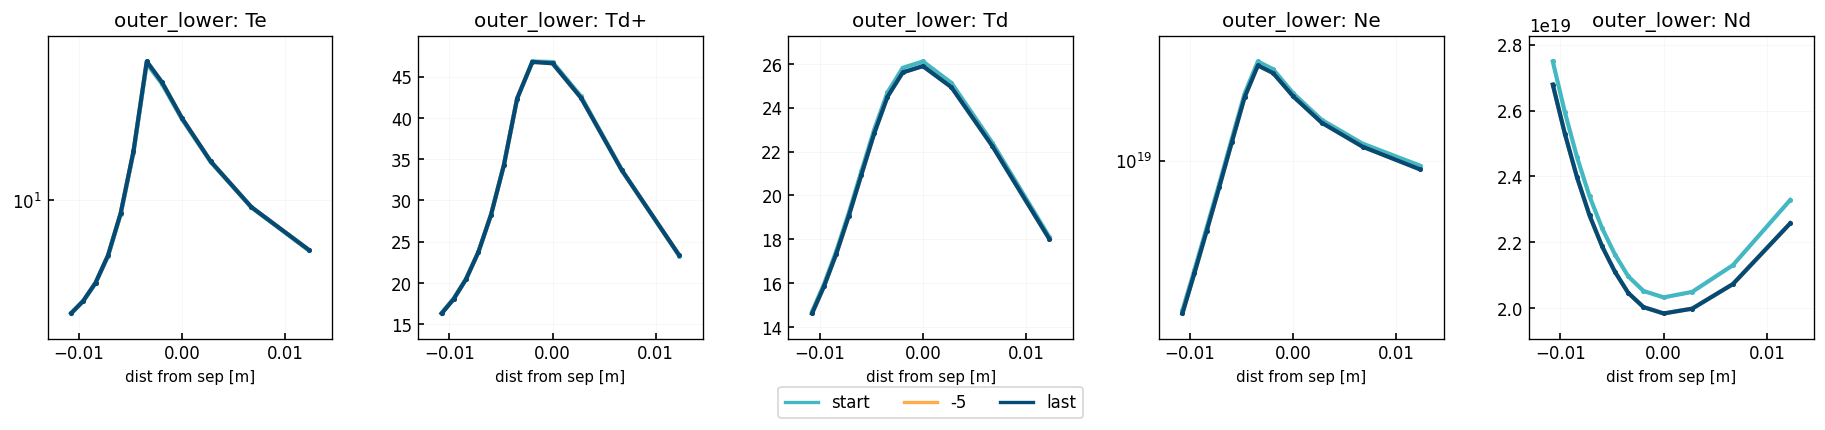

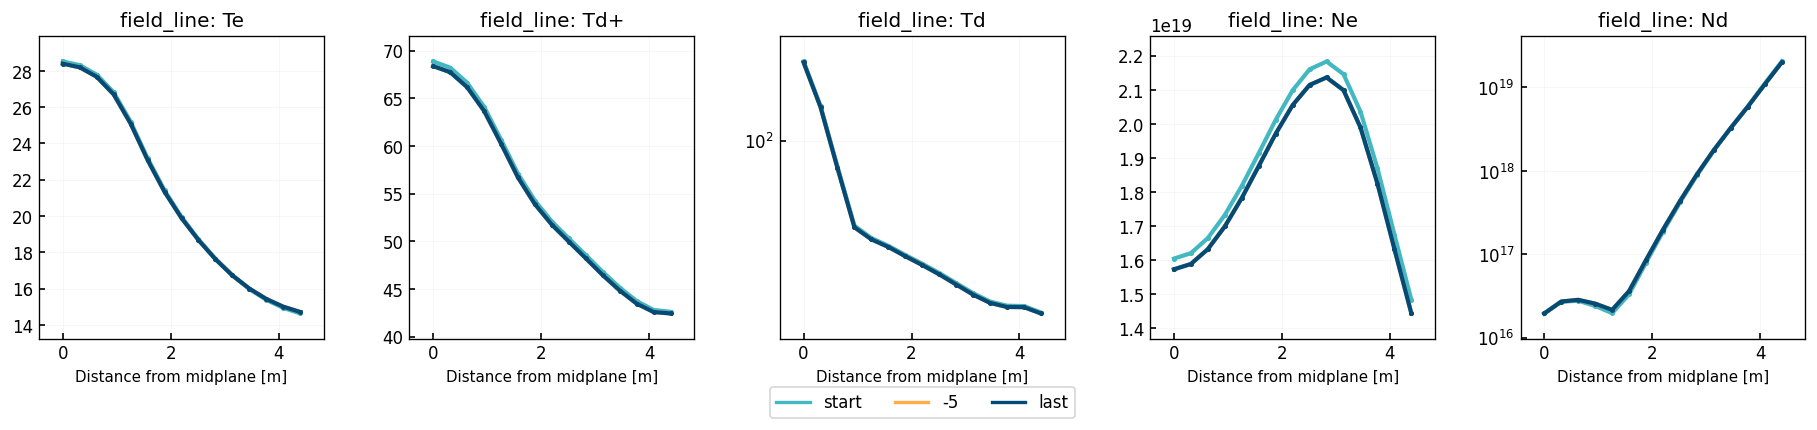

In [4]:
case = "floorfix_allfields"
lineplot(
    {
        "start":cs[case].ds.isel(t=0, x = slice(2,-2)),
        "-5":cs[case].ds.isel(t=-3, x = slice(2,-2)),
        "last":cs[case].ds.isel(t=-1, x = slice(2,-2)),
        # "base":cs["base"].ds.isel(t=-1, x = slice(2,-2)),

    },
    clean_guards = False,
    params = ["Te", "Td+", "Td", "Ne", "Nd"],
    regions = ["omp", "outer_lower", "field_line"],
)

# Compare plasma without AFN

In [8]:
cs.keys()

dict_keys(['base_noAFN', 'base_AFN', 'base_AFN_nocondlim', 'hotneut', 'hotneut_AFN'])

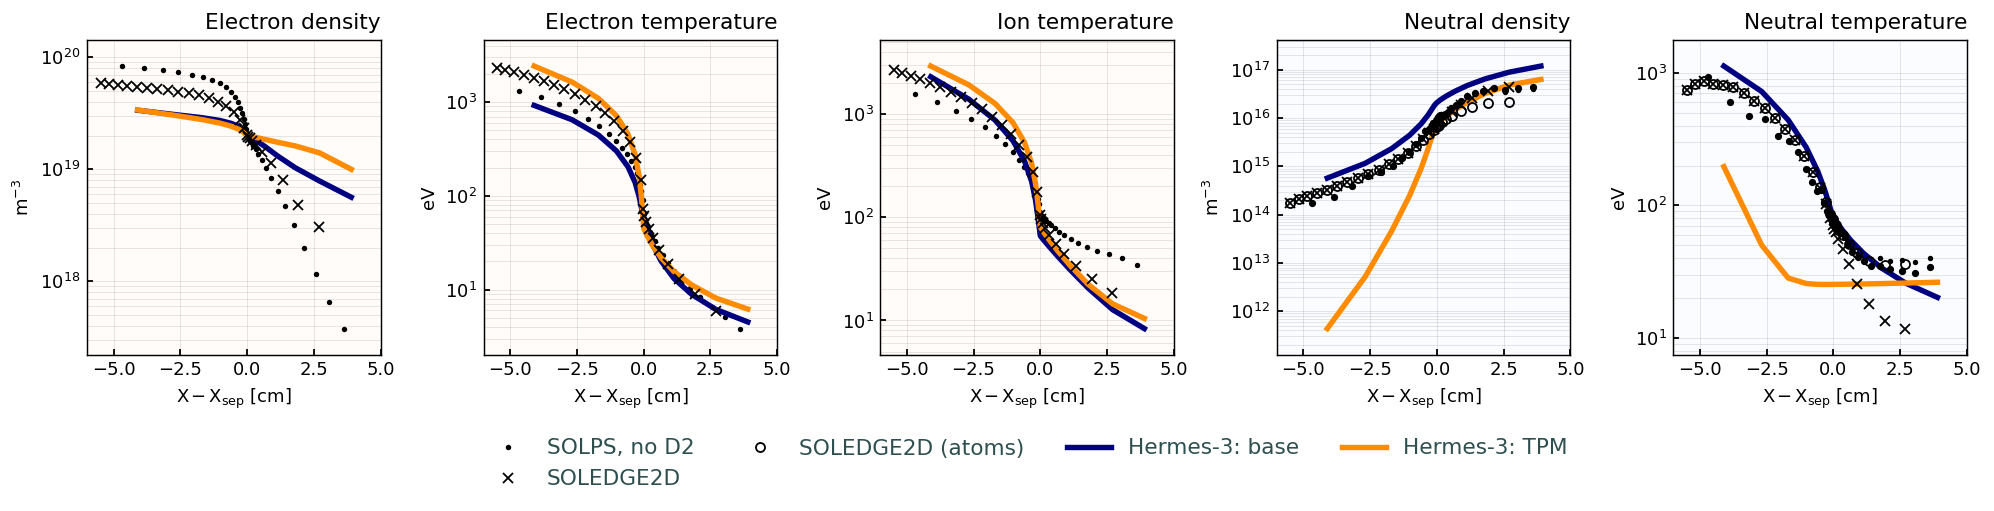

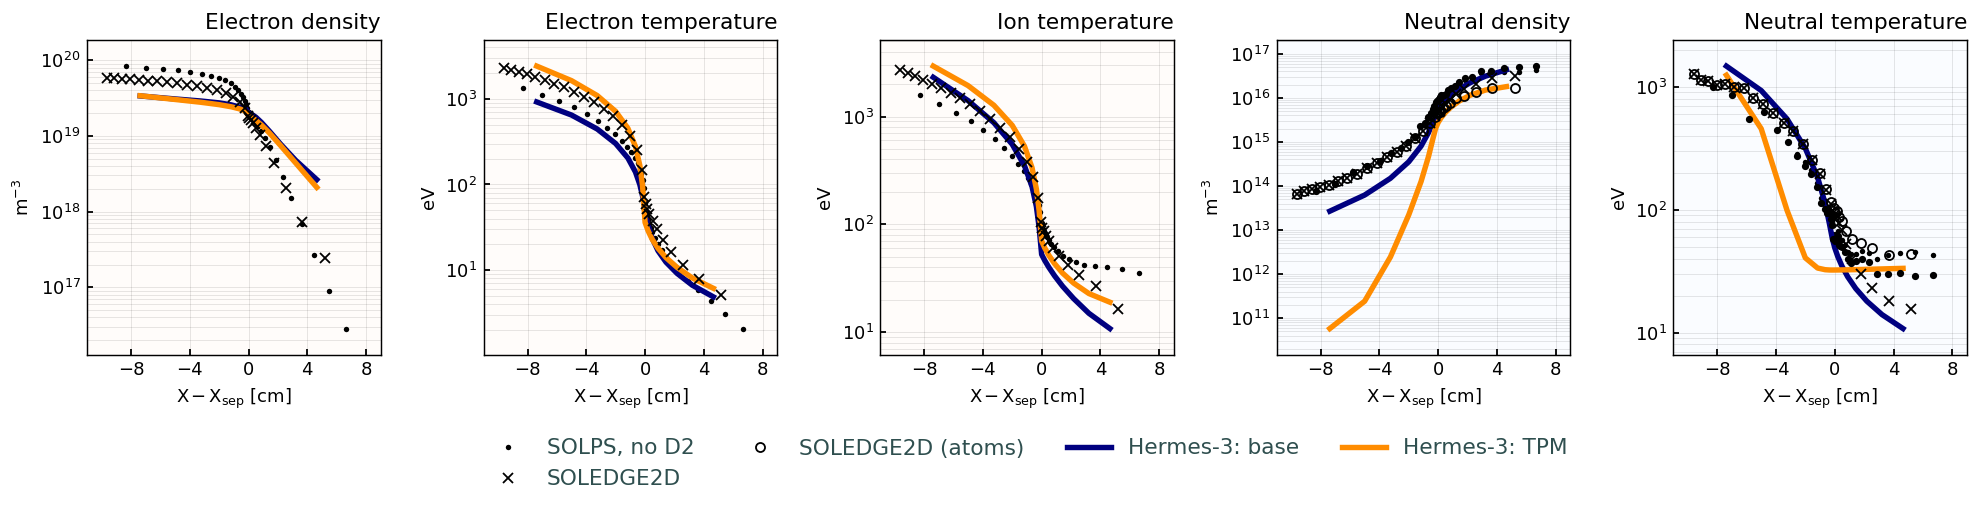

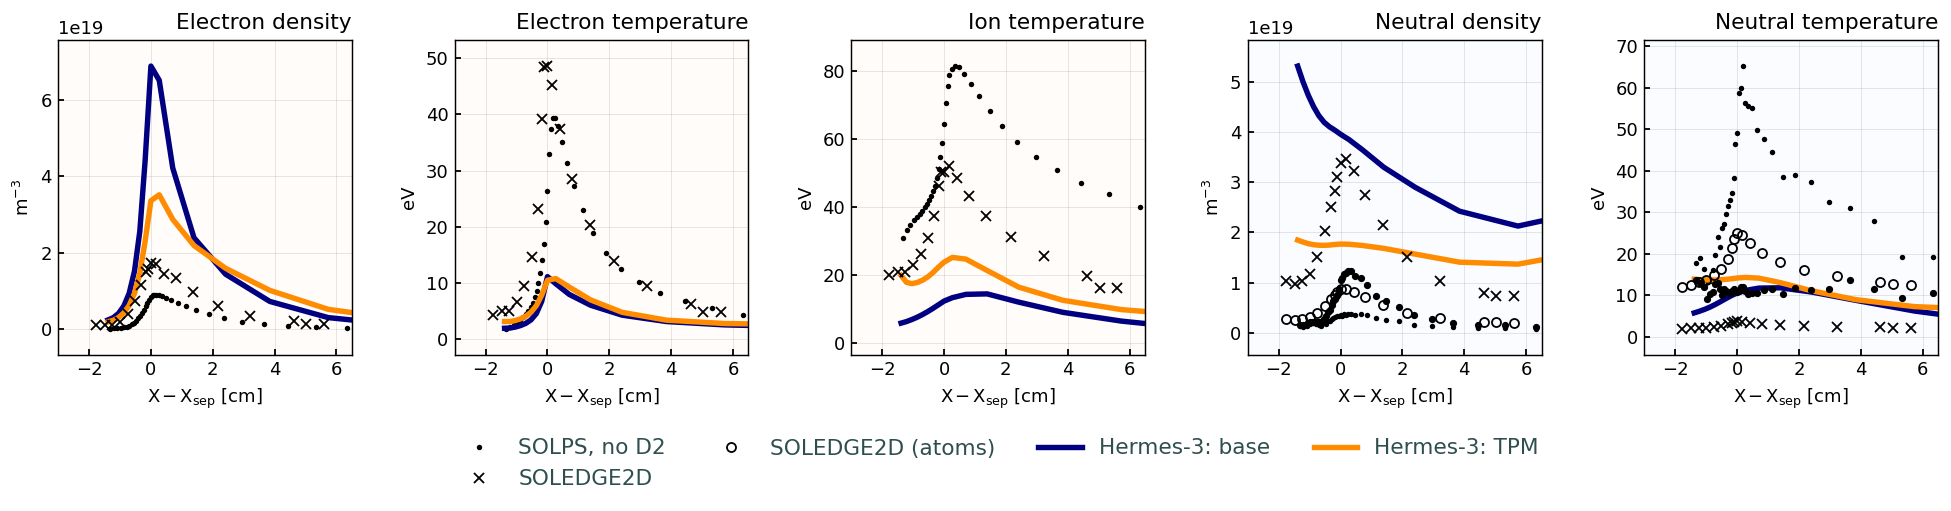

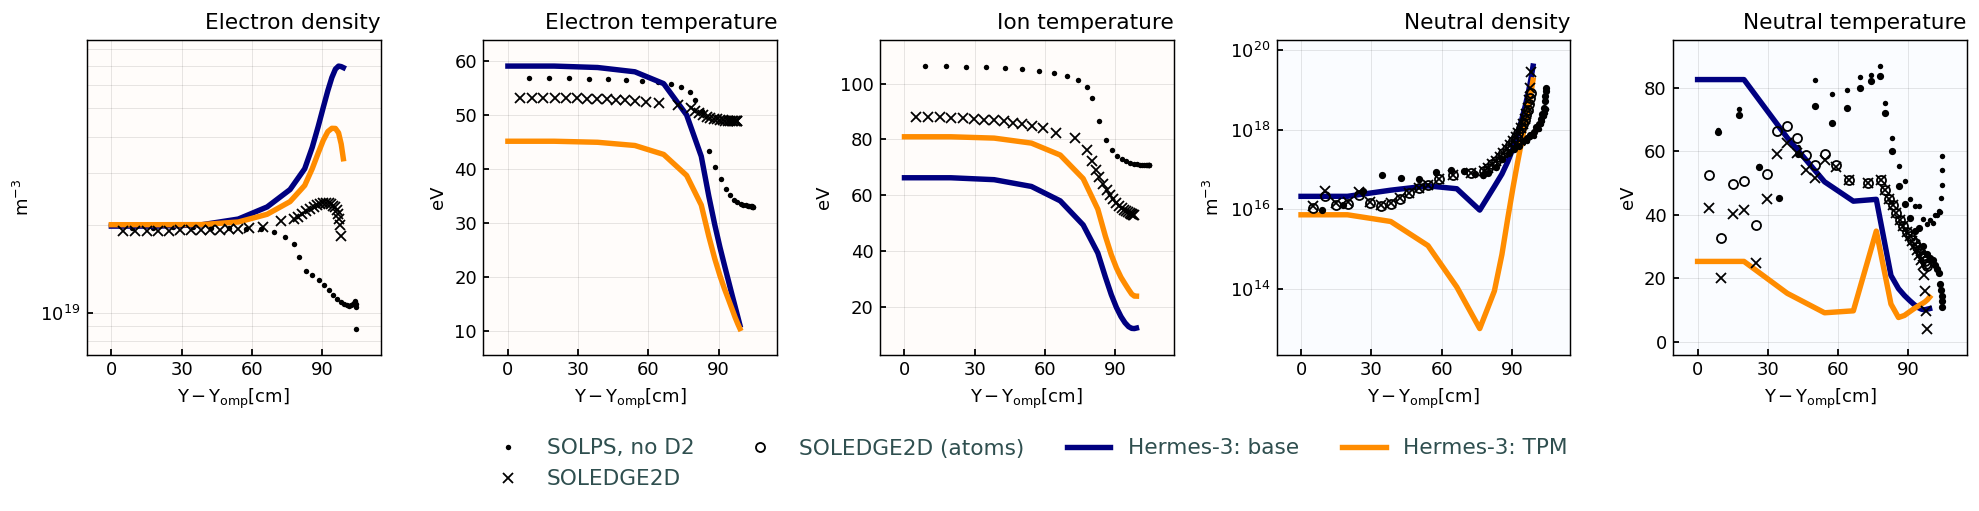

In [42]:
lineplot_compare(
    cases = { 
    "SOLPS, no D2" : dict(data=sp["tightwall_noD2_2e19"], color="black"),
    "SOLEDGE2D" : dict(data=sl["tightwall_2e19"], color="black"),
    r"Hermes-3: base" : dict(data=hr['base_noAFN'], color = "navy"),
    r"Hermes-3: TPM" : dict(data=hr['hotneut'], color = "darkorange"),

    },
    regions = ["omp", "imp", "outer_lower", "outer_fieldline"],  
    params = ["Ne", "Te", "Td+", "Na", "Ta"],
    # params = ["Ne", "Te", "Td+", "Na", "Ta"],
    mode = "log",
    dpi = 100,
    lw = 2,
    legend_nrows =1,
    combine_molecules = True
)

# Compare plasma with AFN

In [23]:
cs.keys()

dict_keys(['base_noAFN', 'base_AFN', 'base_AFN_nocondlim', 'hotneut', 'hotneut_AFN'])

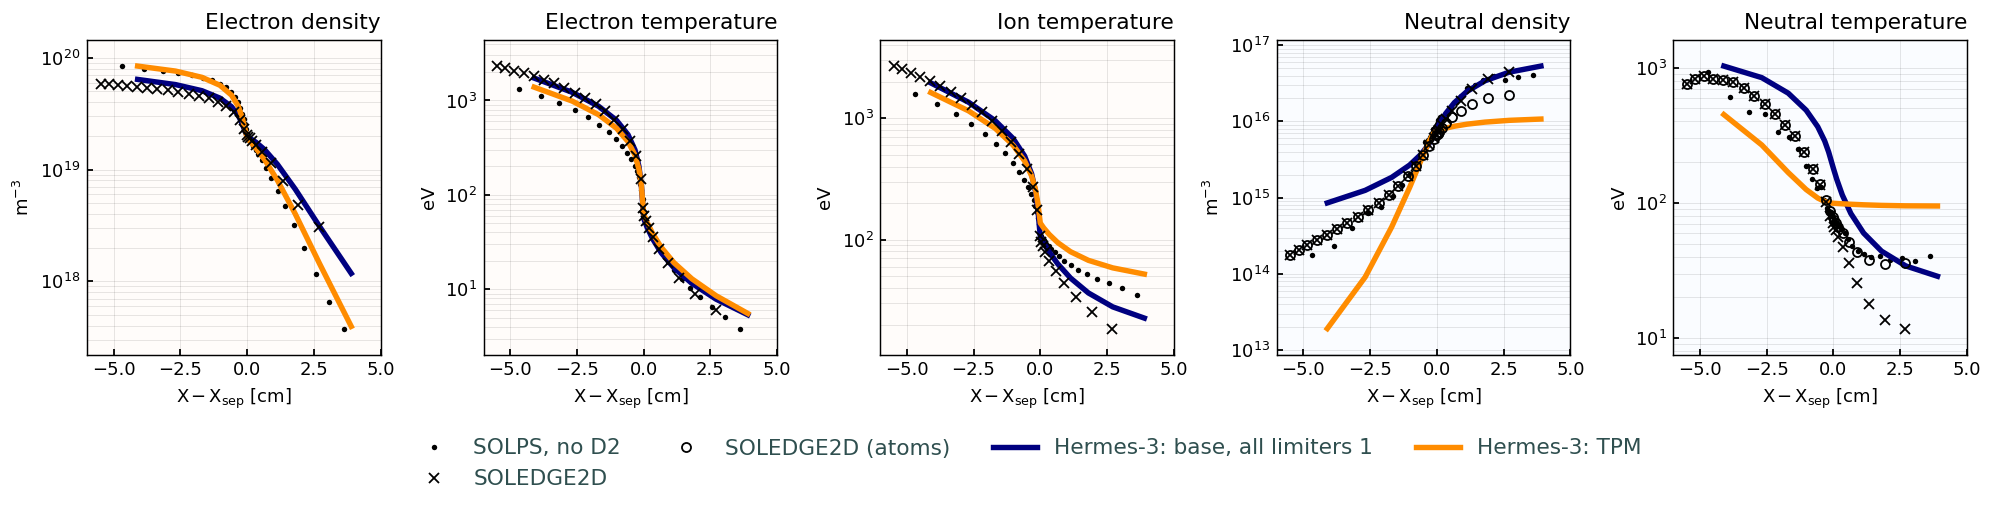

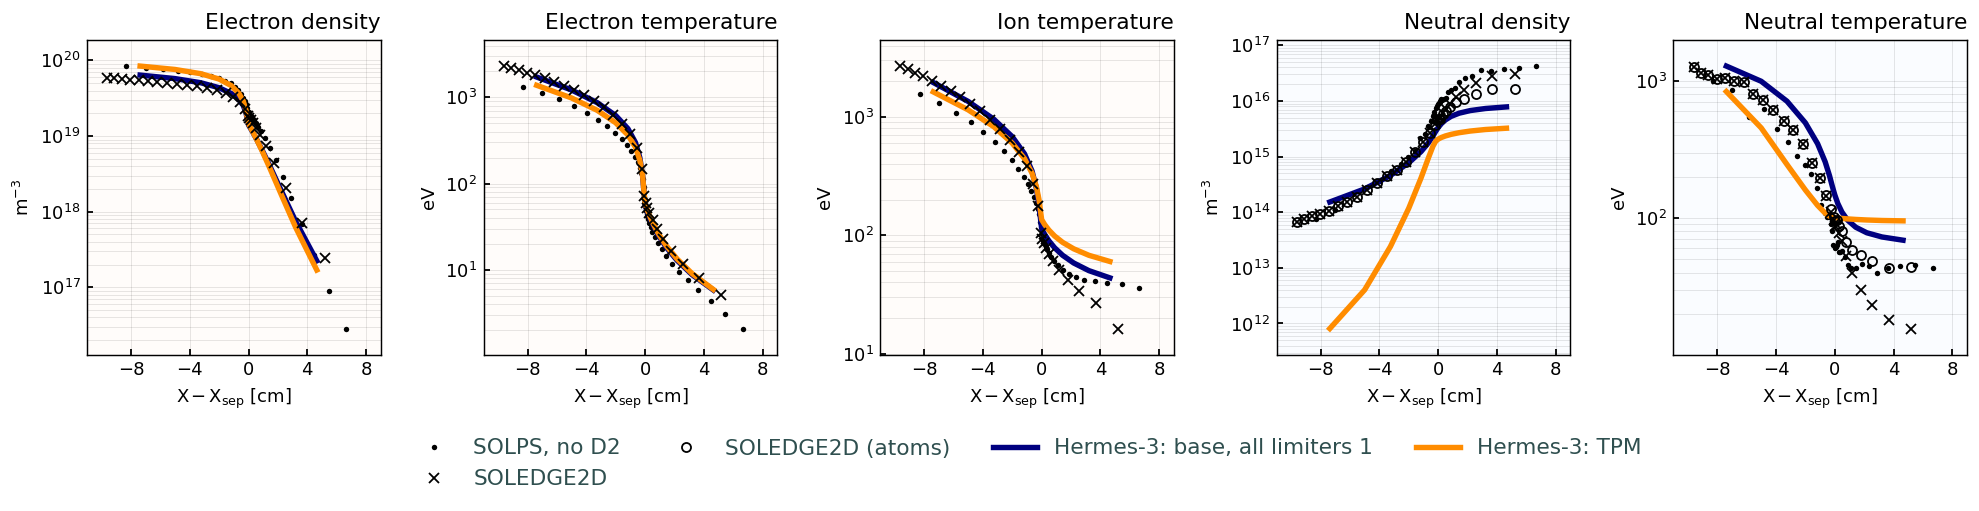

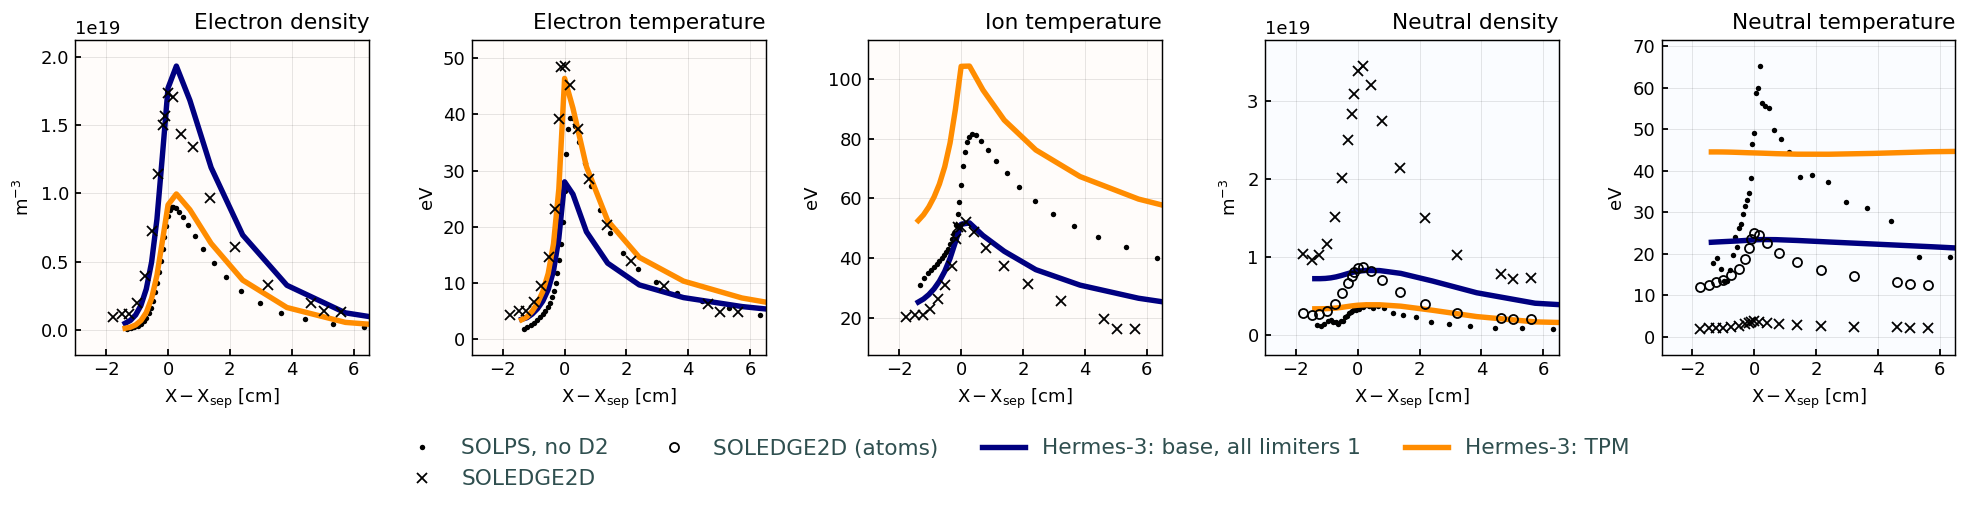

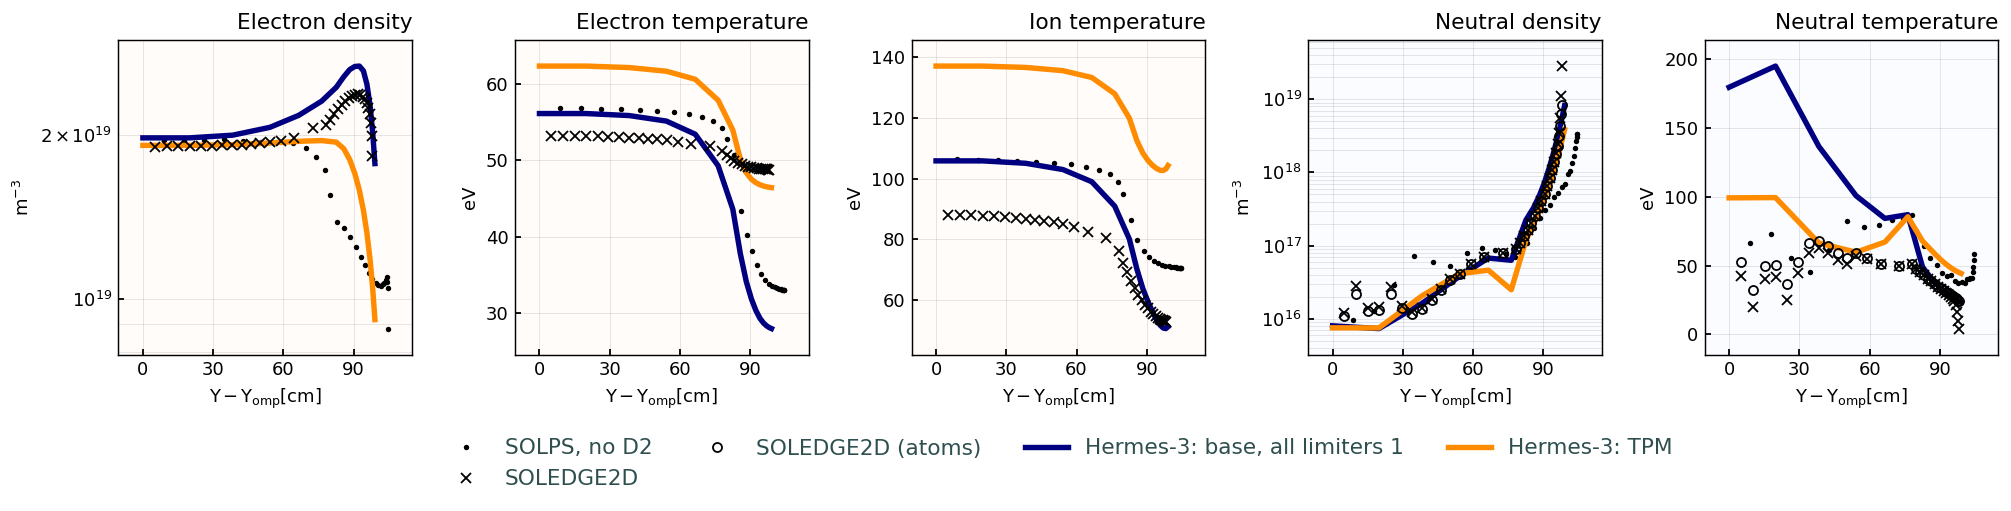

In [47]:
lineplot_compare(
    cases = { 
    "SOLPS, no D2" : dict(data=sp["tightwall_noD2_2e19"], color="black"),
    "SOLEDGE2D" : dict(data=sl["tightwall_2e19"], color="black"),
    r"Hermes-3: base, all limiters 1" : dict(data=hr['base_AFN_nocondlim'], color = "navy"),
    # r"Hermes-3: base, condlim" : dict(data=hr['base_AFN'], color = "skyblue"),
    r"Hermes-3: TPM" : dict(data=hr['hotneut_AFN'], color = "darkorange"),
    # r"Hermes-3: TPM, no pump" : dict(data=hr['hotneut_AFN_nopump'], color = "gold"),

    },
    regions = ["omp", "imp", "outer_lower", "outer_fieldline"],  
    params = ["Ne", "Te", "Td+", "Na", "Ta"],
    # params = ["Ne", "Te", "Td+", "Na", "Ta"],
    mode = "log",
    dpi = 100,
    lw = 2,
    legend_nrows =1,
    combine_molecules = True,
    solps_noD2 = True
)

# Compare to SOLPS no D2

In [123]:
print([x.keys() for x in [cs, sp]])

[dict_keys(['base_noAFN', 'base_AFN', 'base_AFN_nocondlim', 'hotneut', 'hotneut_AFN']), dict_keys(['noiz_core', 'tightwall_2e19', 'tightwall_noD2_1e19', 'tightwall_noD2_2e19', 'tightwall_noD2_3e19'])]


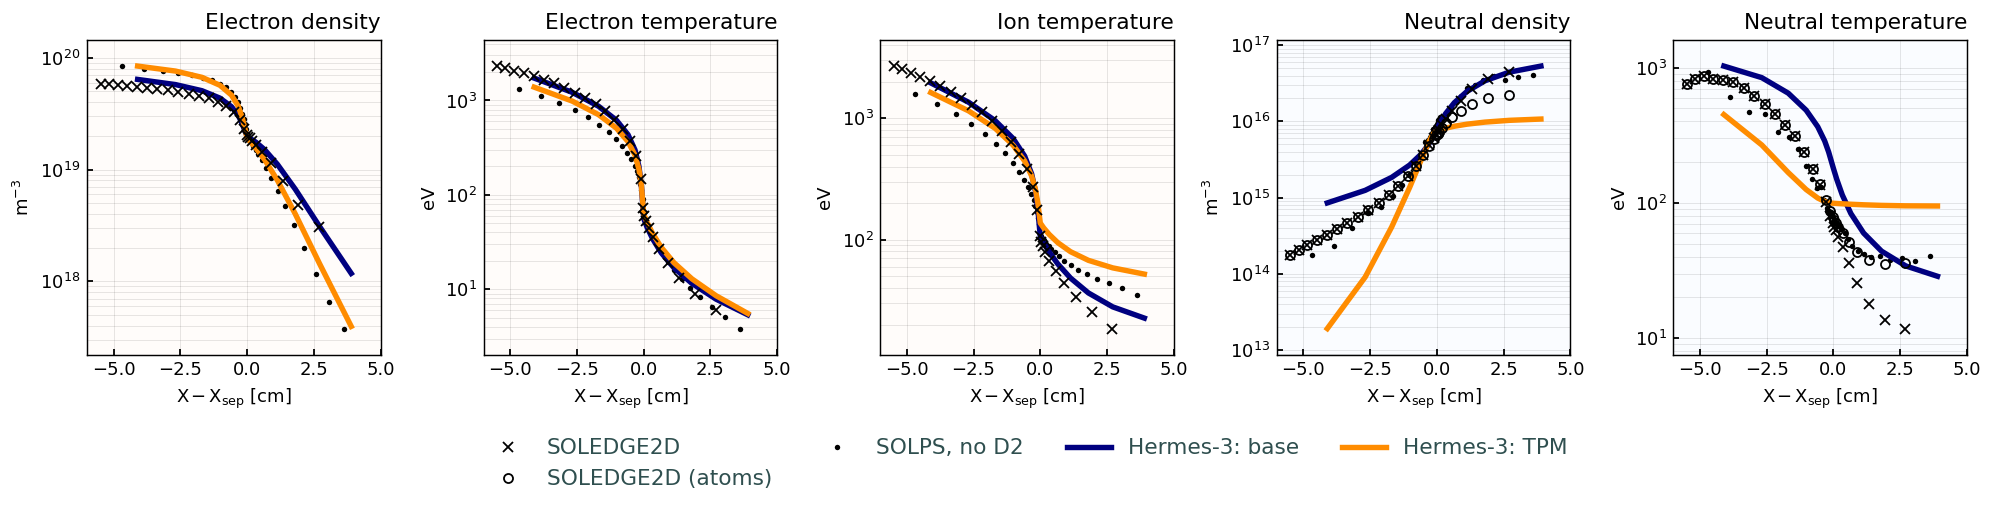

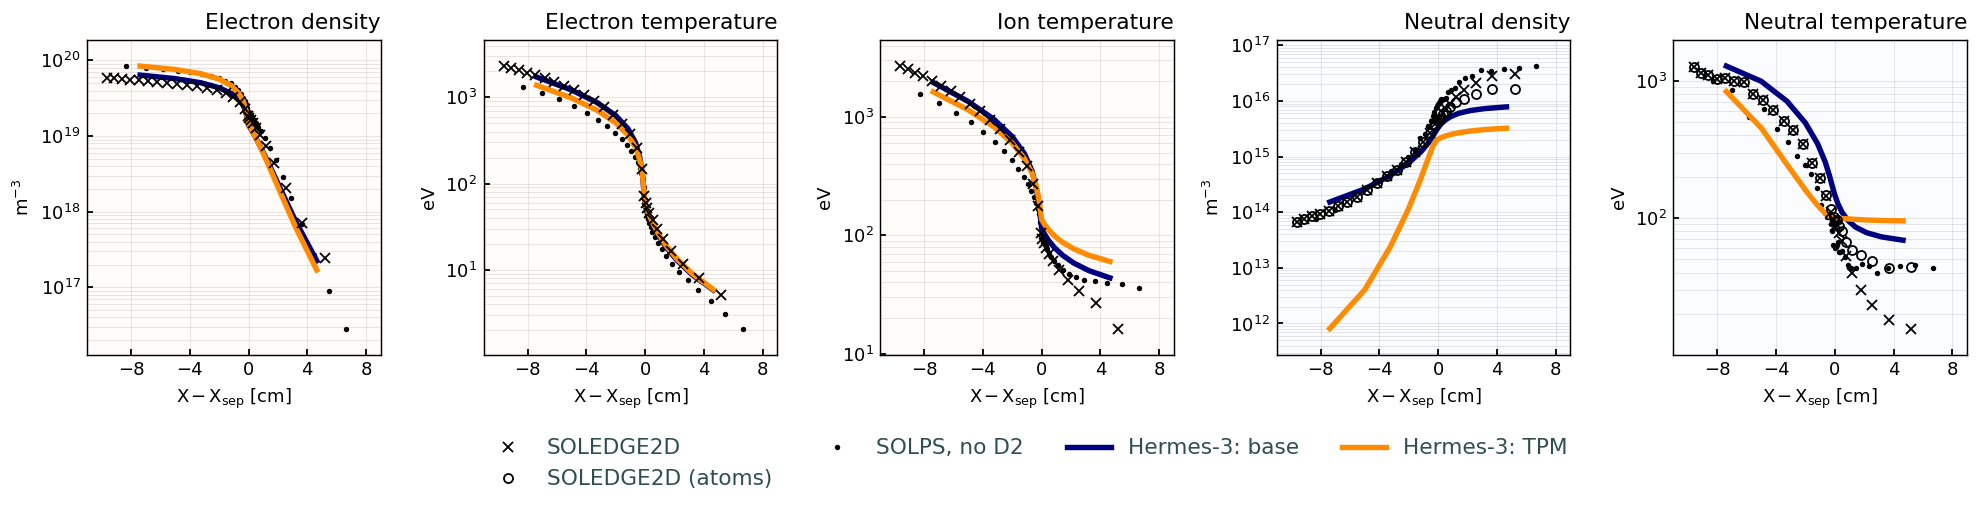

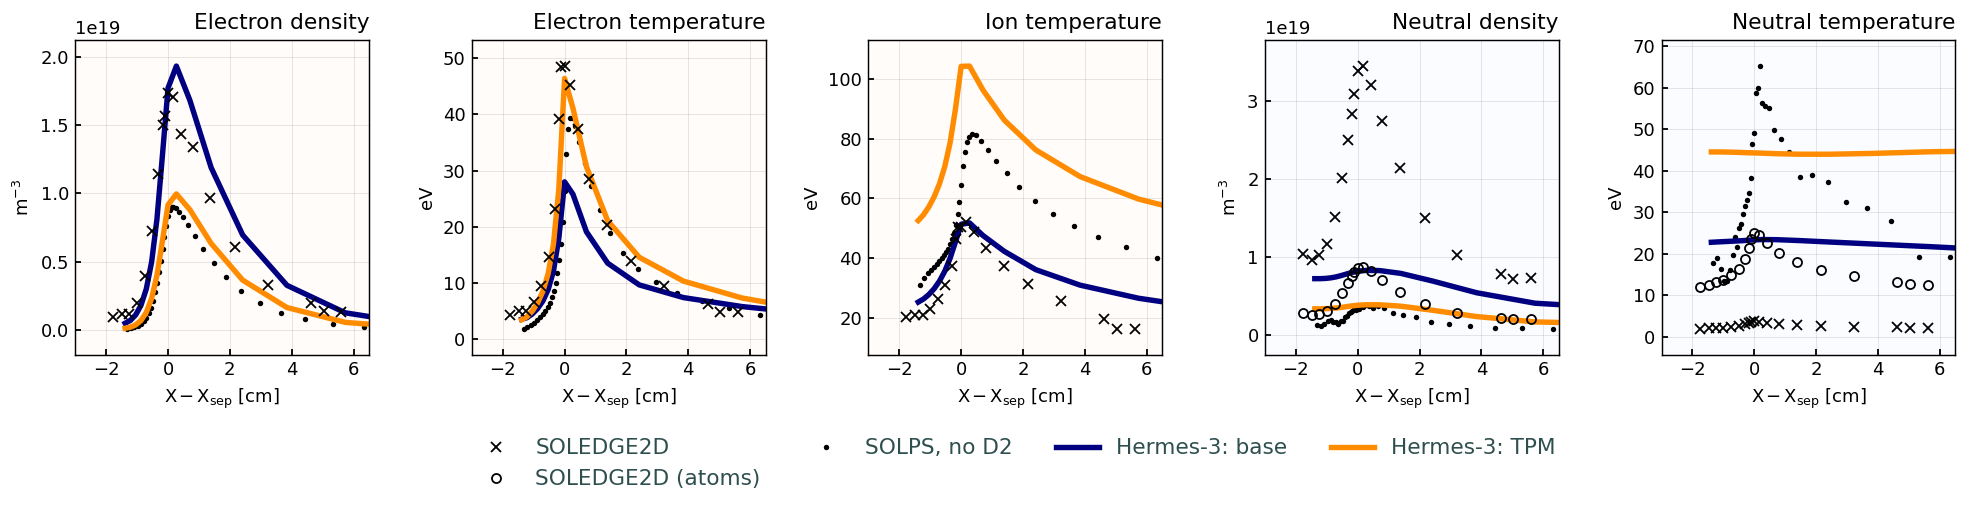

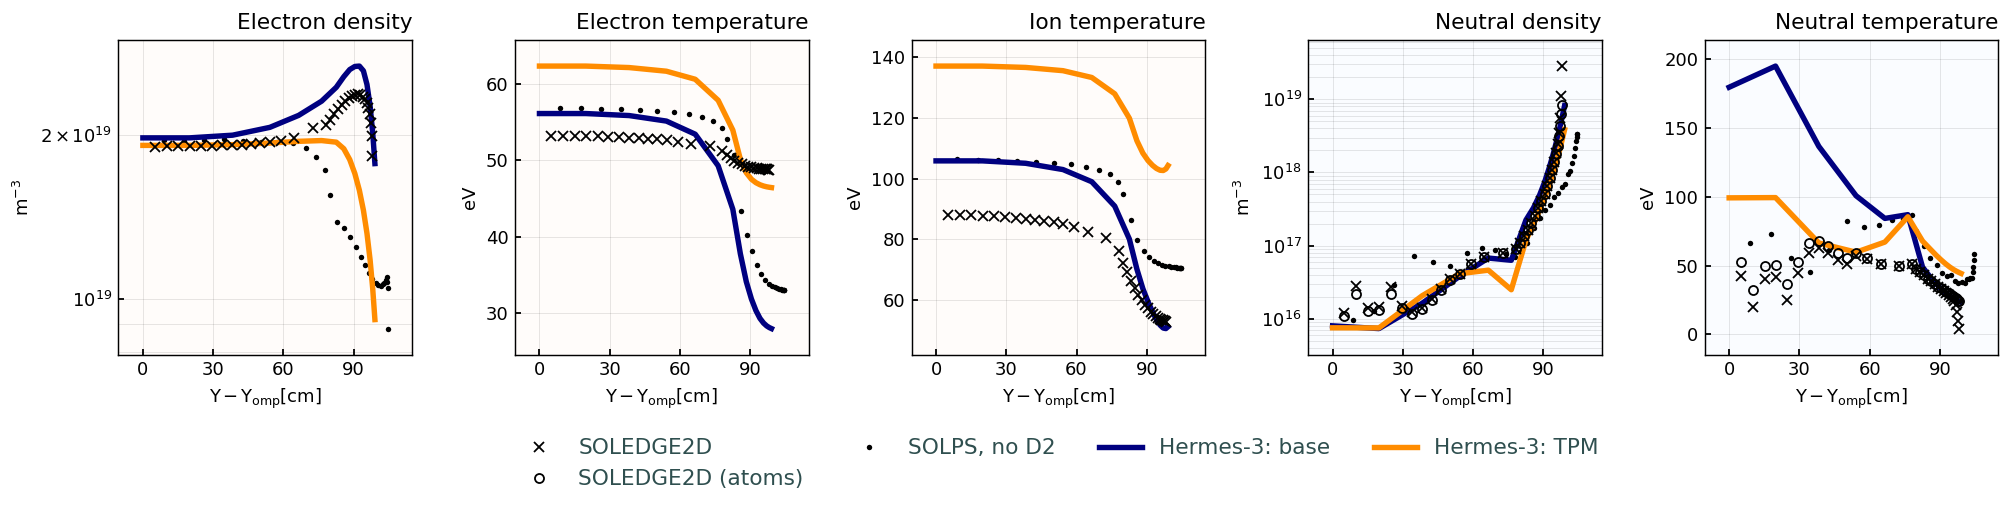

In [41]:
lineplot_compare(
    cases = { 
    "SOLEDGE2D" : dict(data=sl["tightwall_2e19"], color="black"),
    "SOLPS, no D2" : dict(data=sp["tightwall_noD2_2e19"], color="black"),
    r"Hermes-3: base" : dict(data=hr['base_AFN_nocondlim'], color = "navy"),
    # r"Hermes-3: base, condlim" : dict(data=hr['base_AFN'], color = "skyblue"),
    r"Hermes-3: TPM" : dict(data=hr['hotneut_AFN'], color = "darkorange"),
    # r"Hermes-3: TPM, no pump" : dict(data=hr['hotneut_AFN_nopump'], color = "gold"),

    },
    regions = ["omp", "imp", "outer_lower", "outer_fieldline"],  
    params = ["Ne", "Te", "Td+", "Na", "Ta"],
    # params = ["Ne", "Te", "Td+", "Na", "Ta"],
    mode = "log",
    dpi = 100,
    lw = 2,
    legend_nrows =1,
    combine_molecules = True,
    solps_noD2 = True
)

# Wall heat fluxes

## SOLEDGE

In [7]:
plt.close("all")

self = SOLEDGEcase(soledgecases["tightwall_2e19"])
slcWfluxes = self.get_wall_flux_summary()
display(slcWfluxes)

c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)


get_wall_triangle
get_wall_triangles
get_wall_triangles.2: Completed
get_wall_triangle: Completed

 ********** 
 **********
get_wall_triangle
get_wall_triangles
get_wall_triangles.2: Completed
get_wall_triangle: Completed


outer_wall  inner_wall   targets       pfr
E_Total                    0.232057    0.038567  1.265799  0.102674
E_incident_Electron        0.000000    0.000000  0.553930  0.000234
E_incident_Ions            0.000000    0.000000  0.963330  0.001283
E_incident_Atoms           0.210326    0.026182  0.070519  0.081643
E_incident_Molecules       0.000000    0.000000  0.000000  0.000000
E_Radiation                0.021104    0.012336  0.019350  0.019273
E_Radiation_Atoms          0.021104    0.012336  0.019350  0.019273
E_Rad_Recombination        0.000000    0.000000 -0.451635 -0.000603
E_Recombination_in_Wall    0.000627    0.000048  0.110306  0.000843

In [8]:
hflows = []
for case in cs:

    df = calculate_neutral_heat_balance(cs[case].ds.isel(t=-1), mode = "reflection")
    df = df.loc[["total"], :]
    df.index = [case]
    
    hflows.append(df)
    
hflows = pd.concat(hflows, axis = 0)

In [100]:
len([["SOLEDGE2D"] + list(df_nolim.index)][0] + list(df_lim.index))

9

In [20]:
hflows.loc["SOLEDGE2D"] = slcWfluxes.loc["E_incident_Atoms"]
hflows

outer_wall  inner_wall   targets       pfr
base_noAFN            0.151686    0.019225  0.112949  0.116232
base_AFN              0.213527    0.029633  0.095701  0.185909
base_AFN_nocondlim    0.335136    0.045134  0.103080  0.319814
hotneut               0.439884    0.063387  0.252424  0.418491
hotneut_AFN           1.167375    0.131233  0.186950  0.924070
SOLEDGE2D             0.210326    0.026182  0.070519  0.081643

outer_wall    0.210326
inner_wall    0.026182
targets       0.070519
pfr           0.081643
Name: E_incident_Atoms, dtype: float64

In [21]:
hflows.loc[["SOLEDGE2D", "base_noAFN","hotneut"]]

outer_wall  inner_wall   targets       pfr
SOLEDGE2D     0.210326    0.026182  0.070519  0.081643
base_noAFN    0.151686    0.019225  0.112949  0.116232
hotneut       0.439884    0.063387  0.252424  0.418491

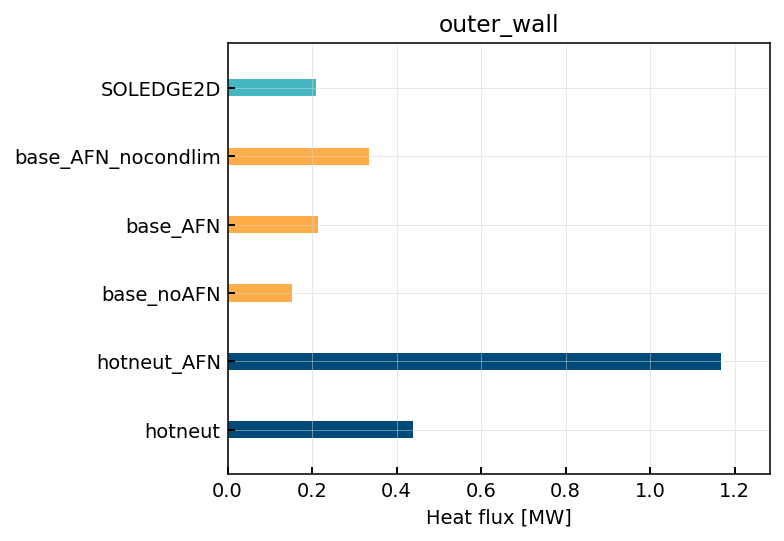

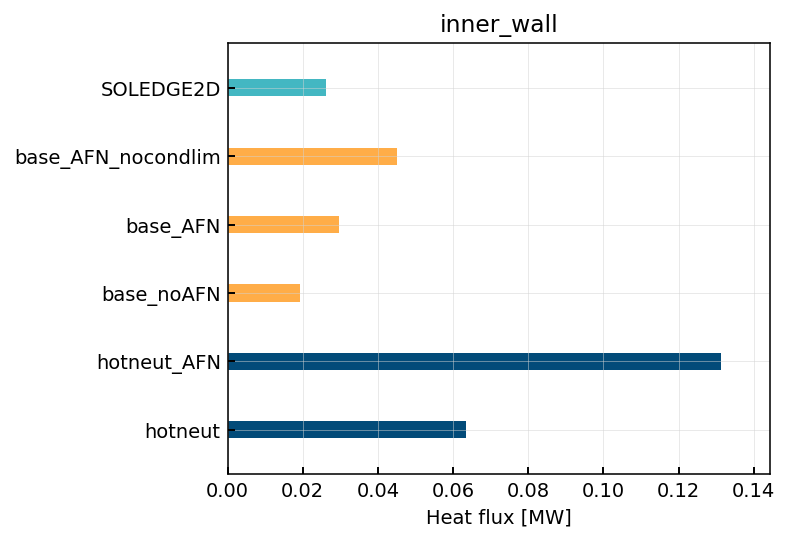

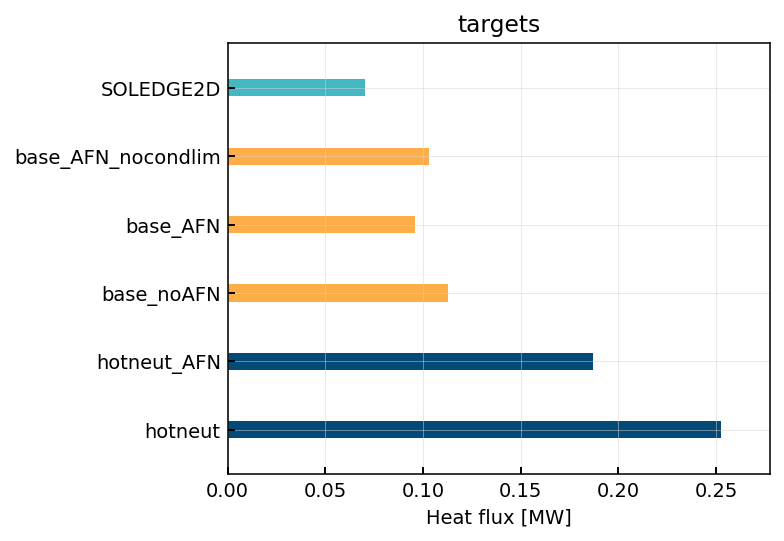

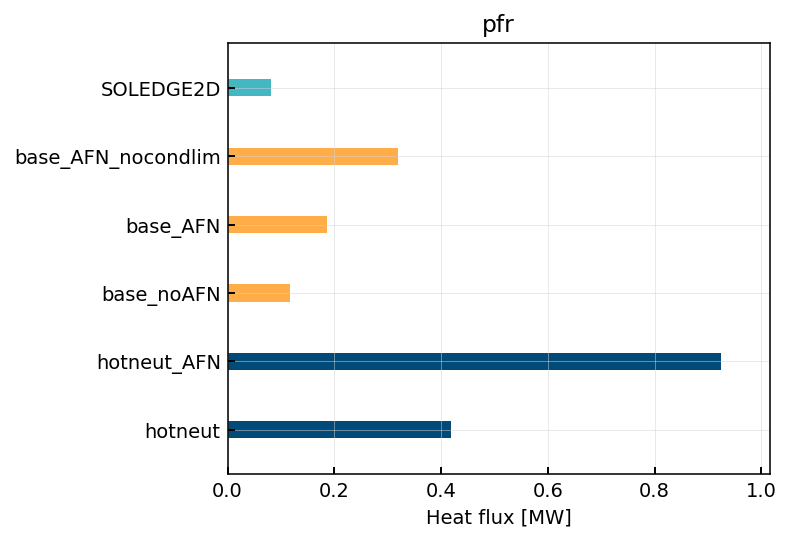

In [9]:
for loc in ["outer_wall", "inner_wall", "targets", "pfr"]:

    fig, ax = plt.subplots()
    dfplot = hflows

    df1 = dfplot.loc[[x for x in dfplot.index if "base" in x], :]
    df2 = dfplot.loc[[x for x in dfplot.index if "base" not in x], :]
    x = np.arange(len(dfplot)+1)
    width = 0.25
    # for i, case in enumerate(dfplot.index):
        # offset = width * i

    ax.barh(len(dfplot), slcWfluxes.loc["E_incident_Atoms", loc], width)
    ax.barh(np.arange(len(df1)) + len(df1) -1, df1[loc], width)
    ax.barh(np.arange(len(df2)), df2[loc], width)
        # ax.bar_label(rects, padding = 3)
        
    ax.set_yticks(x, list(df2.index) + [list(df1.index)][0]  + ["SOLEDGE2D"])
    ax.set_xlabel("Heat flux [MW]")
    ax.set_title(loc)

## State of Td

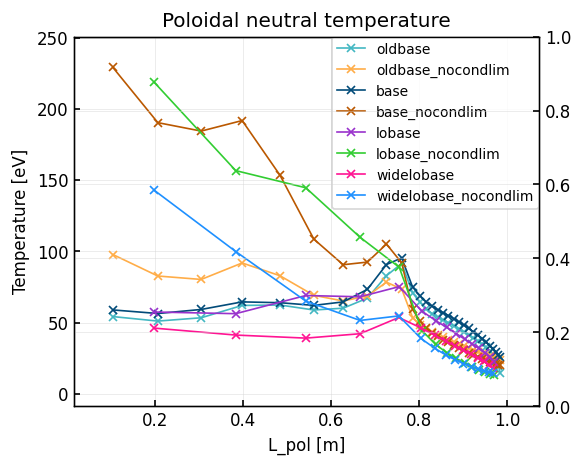

In [8]:

# colors = mpl.cm.get_cmap("plasma", len(cases))(range(len(cases)))
fig, ax = plt.subplots(dpi = 120)

cases = cs.keys()

ax2 = ax.twinx()

# colors = ["teal", "darkorange", "firebrick"]

for i, case in enumerate(cases):
    ds = cs[case].ds.isel(t=-1)
    m = ds.metadata
    # fl = ds.isel(x = m["ixseps1"], theta = slice(41,-2))
    fl = ds.hermesm.select_custom_sol_ring(m["ixseps1"], region = "outer_lower").squeeze()
    dist = np.cumsum(fl["dl"])
    
    if any([x in case for x in ["form2", "form4"]]):
        marker = "x"
    elif any([x in case for x in ["form1", "form3"]]):
        marker = "+"
    else:
        marker = "x"
    ax.plot(dist, fl["Td"], label = case, marker = marker, ms = 5, lw = 1, 
            # color = colors[i]
            )
    
    # try:
    # try:
    #     ax2.plot(dist, fl["Sd+_rec"], label = case, marker = marker, ms = 5, lw = 1)
    # except:
    #     pass
                # color = colors[i])
# ax.plot(dist, fl["Td+"],  marker = "o", ms = 5, lw = 0.5, c = colors[i])
# ax.set_yscale("symlog", linthresh = 1e-3)
ax.set_xlabel("L_pol [m]")
ax.set_ylabel("Temperature [eV]")
ax.set_title("Poloidal neutral temperature")
ax.legend(fontsize="small")
# ax.set_ylim(0,200)

# Detailed analysis

## OMP - profiles

In [27]:
cs.keys()

dict_keys(['base_noAFN', 'base_AFN', 'base_AFN_nocondlim', 'hotneut', 'hotneut_AFN'])

In [12]:
sp.keys()

dict_keys(['noiz_core', 'tightwall_2e19', 'tightwall_noD2_1e19', 'tightwall_noD2_2e19', 'tightwall_noD2_3e19'])

In [8]:
name = "hotneut"
basename = "base_noAFN"
compare  = sp["tightwall_noD2_2e19"]

# name = "hotneut_AFN"
# basename = "base_AFN_nocondlim"
# compare  = sp["tightwall_noD2_2e19"]

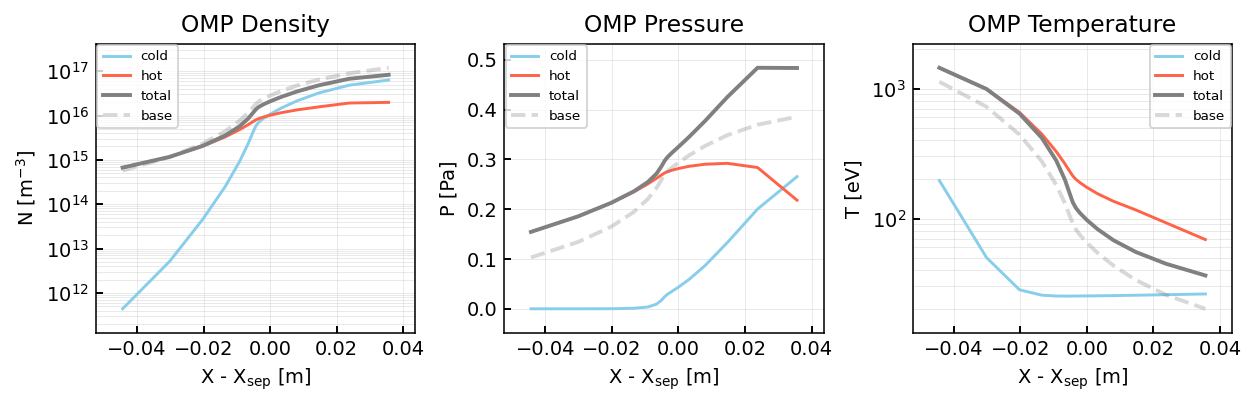

In [19]:
ds = cs[name].ds.isel(t=-1)
reg2 = cs[basename].ds.hermesm.select_region("outer_midplane_a").isel(x = slice(2,-2), t = -1)
reg = ds.hermesm.select_region("outer_midplane_a").isel(x = slice(2,-2))
comp = compare.regions["omp"]
title = "OMP"

fig, axes = plt.subplots(1,3, figsize = (9,3))

x = np.cumsum(reg["dr"]).values
x = x - x[ds.metadata["ixseps1"]]
kwargs = dict(marker = "o", ms = 0)
totkwargs = dict(c = "grey", lw = 2, ls = "-", alpha = 1, label = "total")
basekwargs = dict(c = "grey", lw = 2, marker = "o", ls = "--", ms = 0, alpha = 0.3, markeredgewidth = 0, label = "base")
compkwargs = dict(c = "grey", lw = 0, marker = "x", ms = 1, alpha = 0.3, markeredgewidth = 5, label = "SOLPS")
coldkwargs = dict(label = "cold", c = "skyblue")
hotkwargs = dict(label = "hot", c = "tomato")

ax = axes[0]
ax.set_title(f"{title} Density")
ax.set_yscale("log")
ax.set_ylabel("N [$m^{-3}$]")
ax.plot(x, reg["Nd"], **coldkwargs)
ax.plot(x, reg["Nd*"], **hotkwargs)
ax.plot(x, reg["Nd"]+reg["Nd*"], **totkwargs)
ax.plot(x, reg2["Nd"], **basekwargs)
# ax.plot(comp.index, comp["Na"], **compkwargs)

ax = axes[1]
ax.set_title(f"{title} Pressure")
ax.set_ylabel("P [Pa]")
ax.plot(x, reg["Pd"], **coldkwargs)
ax.plot(x, reg["Pd*"], **hotkwargs)
ax.plot(x, reg["Pd"]+reg["Pd*"], **totkwargs)
ax.plot(x, reg2["Pd"], **basekwargs)
# ax.plot(comp.index, comp["Pa"], **compkwargs)

ax = axes[2]
ax.set_title(f"{title} Temperature")
ax.set_ylabel("T [eV]")
ax.set_yscale("log")
ax.plot(x, reg["Td"], **coldkwargs)
ax.plot(x, reg["Td*"], **hotkwargs)
ax.plot(x, (reg["Pd"]+reg["Pd*"])/(reg["Nd*"]+reg["Nd"])/constants("q_e"), **totkwargs)
ax.plot(x, reg2["Td"], **basekwargs)
# ax.plot(comp.index, comp["Ta"], **compkwargs)

for ax in axes:
    ax.legend(fontsize = "x-small")
    ax.set_xlabel("X - $X_{sep}$ [m]")

    ax.set_xscale("linear")
    
fig.tight_layout()


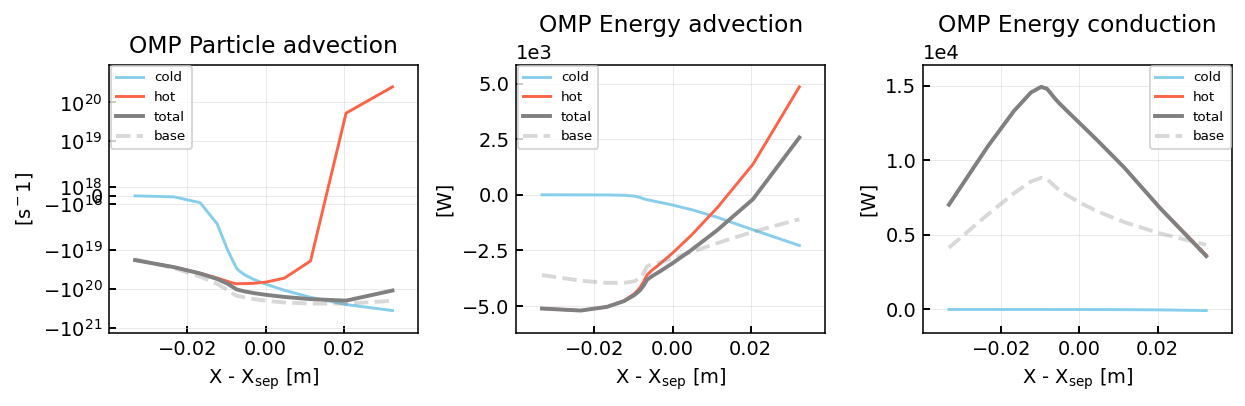

In [21]:
ds = cs[name].ds.isel(t=-1)
reg2 = cs[basename].ds.hermesm.select_region("outer_midplane_a").isel(x = slice(3,-2), t = -1)
reg = ds.hermesm.select_region("outer_midplane_a").isel(x = slice(3,-2))
title = "OMP"

fig, axes = plt.subplots(1,3, figsize = (9,3))

x = np.cumsum(reg["dr"]).values
x = x - x[ds.metadata["ixseps1"]]
totkwargs = dict(c = "grey", lw = 2, ls = "-", alpha = 1, label = "total")
basekwargs = dict(c = "grey", lw = 2, marker = "o", ls = "--", ms = 0, alpha = 0.3, markeredgewidth = 0, label = "base")
compkwargs = dict(c = "grey", lw = 0, marker = "x", ms = 1, alpha = 0.3, markeredgewidth = 5, label = "SOLPS")
coldkwargs = dict(label = "cold", c = "skyblue")
hotkwargs = dict(label = "hot", c = "tomato")

ax = axes[0]
ax.set_title("OMP Particle advection")
ax.set_yscale("symlog", linthresh = 5e18)
ax.set_ylabel("[$s^-1$]")
ax.plot(x, reg["pf_perp_diff_L_d"], **coldkwargs)
ax.plot(x, reg["pf_perp_diff_L_d*"], **hotkwargs)
ax.plot(x, reg["pf_perp_diff_L_d"]+reg["pf_perp_diff_L_d*"], **totkwargs)
ax.plot(x, reg2["pf_perp_diff_L_d"], **basekwargs)

ax = axes[1]
ax.set_title("OMP Energy advection")
ax.set_ylabel("[W]")
ax.plot(x, reg["hf_perp_conv_L_d"], **coldkwargs)
ax.plot(x, reg["hf_perp_conv_L_d*"], **hotkwargs)
ax.plot(x, reg["hf_perp_conv_L_d"]+reg["hf_perp_conv_L_d*"], **totkwargs)
ax.plot(x, reg2["hf_perp_conv_L_d"], **basekwargs)

ax = axes[2]
ax.set_title("OMP Energy conduction")
ax.set_ylabel("[W]")
ax.plot(x, reg["hf_perp_diff_L_d"], **coldkwargs)
ax.plot(x, reg["hf_perp_diff_L_d*"], **hotkwargs)
ax.plot(x, (reg["hf_perp_diff_L_d"]+reg["hf_perp_diff_L_d*"]), **totkwargs)
ax.plot(x, reg2["hf_perp_diff_L_d"], **basekwargs)



for ax in axes:
    ax.legend(fontsize = "x-small")
    ax.set_xlabel("X - $X_{sep}$ [m]")

    ax.set_xscale("linear")
    
fig.tight_layout()


## OMP - transport

In [80]:
for case in cs:
    cs[case].ds = calculate_radial_fluxes(cs[case].ds)

## OMP - Limiters

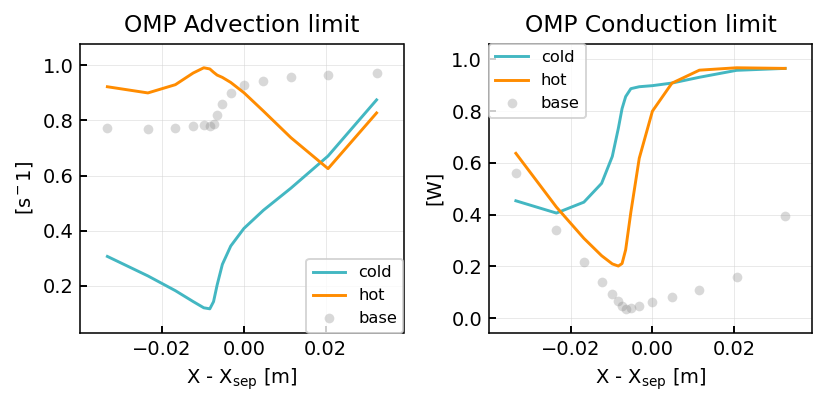

In [82]:
ds = cs[name].ds.isel(t=-1)
reg2 = cs[basename].ds.hermesm.select_region("outer_midplane_a").isel(x = slice(3,-2), t = -1)
reg = ds.hermesm.select_region("outer_midplane_a").isel(x = slice(3,-2))
title = "OMP"

fig, axes = plt.subplots(1,2, figsize = (6,3))

x = np.cumsum(reg["dr"]).values
x = x - x[ds.metadata["ixseps1"]]
kwargs = dict(marker = "o", ms = 0)
totkwargs = dict(c = "grey", lw = 4, alpha = 0.2)
basekwargs = dict(c = "grey", lw = 0, marker = "o", ms = 5, alpha = 0.3, markeredgewidth = 0)

ax = axes[0]
ax.set_title("OMP Advection limit")
# ax.set_yscale("symlog", linthresh = 5e18)
ax.set_ylabel("[$s^-1$]")
ax.plot(x, reg["particle_flux_factor_d"], label = "cold", **kwargs)
ax.plot(x, reg["particle_flux_factor_d*"], label = "hot", c = "darkorange", **kwargs)
# ax.plot(x, reg["pf_perp_diff_L_d"]+reg["pf_perp_diff_L_d*"], label = "total", **totkwargs)
ax.plot(x, reg2["particle_flux_factor_d"], label = "base", **basekwargs)

ax = axes[1]
ax.set_title("OMP Conduction limit")
ax.set_ylabel("[W]")
ax.plot(x, reg["heat_flux_factor_d"], label = "cold", **kwargs)
ax.plot(x, reg["heat_flux_factor_d*"], label = "hot", c = "darkorange", **kwargs)
ax.plot(x, reg2["heat_flux_factor_d"], label = "base", **basekwargs)


for ax in axes:
    ax.legend(fontsize = "small")
    ax.set_xlabel("X - $X_{sep}$ [m]")

    ax.set_xscale("linear")
    
fig.tight_layout()


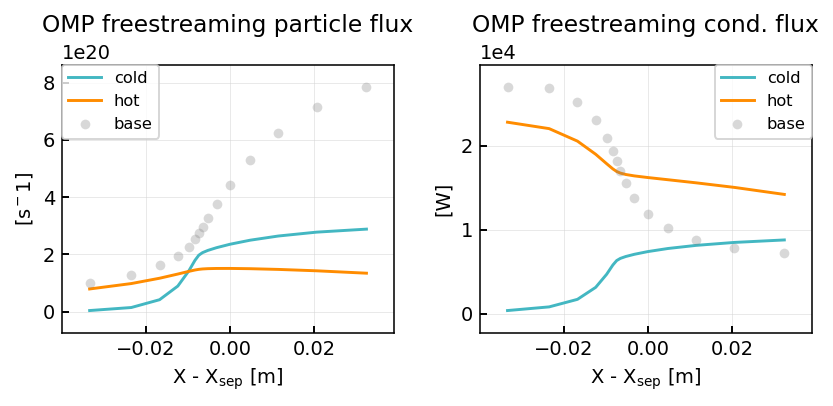

In [70]:
ds = cs[name].ds.isel(t=-1)
reg2 = cs[basename].ds.hermesm.select_region("outer_midplane_a").isel(x = slice(3,-2), t = -1)
reg = ds.hermesm.select_region("outer_midplane_a").isel(x = slice(3,-2))
title = "OMP"

fig, axes = plt.subplots(1,2, figsize = (6,3))

x = np.cumsum(reg["dr"]).values
x = x - x[ds.metadata["ixseps1"]]
kwargs = dict(marker = "o", ms = 0)
totkwargs = dict(c = "grey", lw = 4, alpha = 0.2)
basekwargs = dict(c = "grey", lw = 0, marker = "o", ms = 5, alpha = 0.3, markeredgewidth = 0)

ax = axes[0]
ax.set_title(f"{title} freestreaming particle flux")
# ax.set_yscale("symlog", linthresh = 5e18)
ax.set_ylabel("[$s^-1$]")
ax.plot(x, reg["Nd"] * 0.25 * np.sqrt(8/np.pi * reg["Td"]*constants("q_e")/(constants("mass_p")*2)), label = "cold", **kwargs)
ax.plot(x, reg["Nd*"] * 0.25 * np.sqrt(8/np.pi * reg["Td*"]*constants("q_e")/(constants("mass_p")*2)), label = "hot", c = "darkorange", **kwargs)
ax.plot(x, reg2["Nd"] * 0.25 * np.sqrt(8/np.pi * reg2["Td"]*constants("q_e")/(constants("mass_p")*2)), label = "base", **basekwargs)

ax = axes[1]
ax.set_title(f"{title} freestreaming cond. flux")
ax.set_ylabel("[W]")
ax.plot(x, reg["Pd"] * np.sqrt(2/np.pi * reg["Td"]*constants("q_e")/(constants("mass_p")*2)), label = "cold", **kwargs)
ax.plot(x, reg["Pd*"] * np.sqrt(2/np.pi * reg["Td*"]*constants("q_e")/(constants("mass_p")*2)), label = "hot", c = "darkorange", **kwargs)
ax.plot(x, reg2["Pd"] * np.sqrt(2/np.pi * reg2["Td"]*constants("q_e")/(constants("mass_p")*2)), label = "base", **basekwargs)

# ax = axes[2]
# ax.set_title("OMP Energy conduction")
# ax.set_ylabel("[W]")
# ax.plot(x, reg["hf_perp_diff_L_d"], label = "cold", **kwargs)
# ax.plot(x, reg["hf_perp_diff_L_d*"], label = "hot", c = "darkorange", **kwargs)
# ax.plot(x, (reg["hf_perp_diff_L_d"]+reg["hf_perp_diff_L_d*"]), label = "total", **totkwargs)
# ax.plot(x, reg2["hf_perp_diff_L_d"], label = "base", **basekwargs)


for ax in axes:
    ax.legend(fontsize = "small")
    ax.set_xlabel("X - $X_{sep}$ [m]")

    ax.set_xscale("linear")
    
fig.tight_layout()


## OMP - sources

Text(0.5, 0, 'X - $X_{sep}$ [m]')

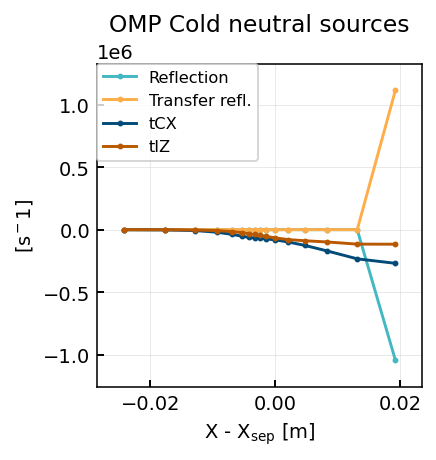

In [11]:
ds = cs["hnthresh20"].ds.isel(t=-1)
reg = ds.hermesm.select_region("outer_midplane_a").isel(x = slice(2,-2)).squeeze()

fig, ax = plt.subplots(1, figsize = (3,3))

x = np.cumsum(reg["dr"]).values
x = x - x[ds.metadata["ixseps1"]]
kwargs = dict(marker = "o", ms = 2)

ax.set_title("OMP Cold neutral sources")
# ax.set_yscale("symlog", linthresh = 5e18)
ax.set_ylabel("[$s^-1$]")
ax.plot(x, reg["Ed_wall_refl"], label = "Reflection", **kwargs)
ax.plot(x, reg["Edd*_wall_refl"], label = "Transfer refl.", **kwargs)
# ax.plot(x, reg["Edd+_cx"], label = "CX", **kwargs)
ax.plot(x, reg["Edd+_cxt"], label = "tCX", **kwargs)
ax.plot(x, reg["Edd+_iz"]*-1, label = "tIZ", **kwargs)

ax.legend(fontsize = "small")
ax.set_xlabel("X - $X_{sep}$ [m]")



## Target

In [30]:
len(x)

12

In [28]:
basename

'base_noAFN'

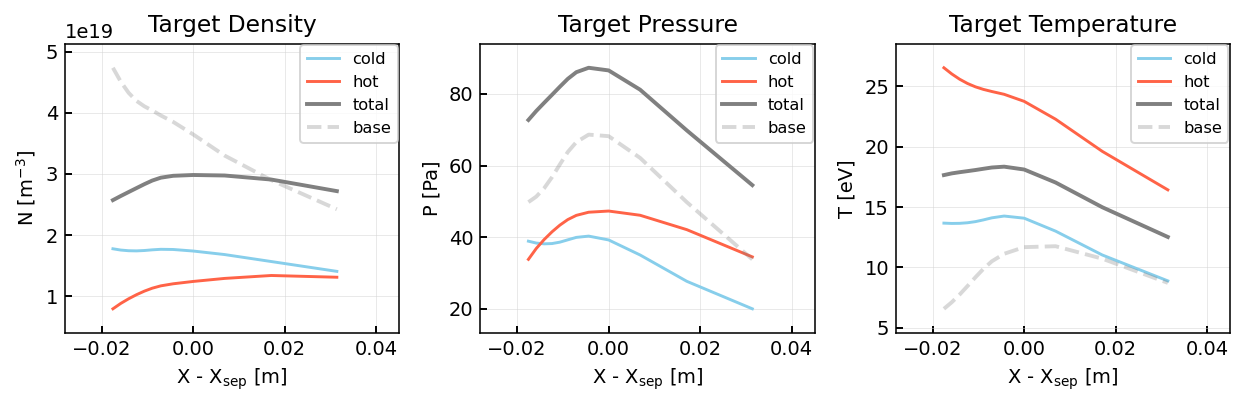

In [23]:
ds = cs[name].ds.isel(t=-1)
reg = ds.hermesm.select_region("outer_lower_target").isel(x = slice(2,-2))
reg2 = cs[basename].ds.hermesm.select_region("outer_lower_target").isel(x = slice(2,-2), t = -1)
comp = compare.regions["outer_lower"]
title = "Target"

fig, axes = plt.subplots(1,3, figsize = (9,3))

x = np.cumsum(reg["dr"]).values
x = x - x[ds.metadata["ixseps1"] - 2]
kwargs = dict(marker = "o", ms = 0)
totkwargs = dict(c = "grey", lw = 2, ls = "-", alpha = 1, label = "total")
basekwargs = dict(c = "grey", lw = 2, marker = "o", ls = "--", ms = 0, alpha = 0.3, markeredgewidth = 0, label = "base")
compkwargs = dict(c = "grey", lw = 0, marker = "x", ms = 1, alpha = 0.3, markeredgewidth = 5, label = "SOLPS")
coldkwargs = dict(label = "cold", c = "skyblue")
hotkwargs = dict(label = "hot", c = "tomato")

ax = axes[0]
ax.set_title(f"{title} Density")
# ax.set_yscale("log")
ax.set_ylabel("N [$m^{-3}$]")
ax.plot(x, reg["Nd"], **coldkwargs)
ax.plot(x, reg["Nd*"], **hotkwargs)
ax.plot(x, reg["Nd"]+reg["Nd*"], **totkwargs)
ax.plot(x, reg2["Nd"], **basekwargs)
# ax.plot(comp.index, comp["Na"], **compkwargs)

ax = axes[1]
ax.set_title(f"{title} Pressure")
ax.set_ylabel("P [Pa]")
ax.plot(x, reg["Pd"], **coldkwargs)
ax.plot(x, reg["Pd*"], **hotkwargs)
ax.plot(x, reg["Pd"]+reg["Pd*"], **totkwargs)
ax.plot(x, reg2["Pd"], **basekwargs)
# ax.plot(comp.index, comp["Pa"], **compkwargs)

ax = axes[2]
ax.set_title(f"{title} Temperature")
ax.set_ylabel("T [eV]")
# ax.set_yscale("log")
ax.plot(x, reg["Td"], **coldkwargs)
ax.plot(x, reg["Td*"], **hotkwargs)
ax.plot(x, (reg["Pd"]+reg["Pd*"])/(reg["Nd*"]+reg["Nd"])/constants("q_e"), **totkwargs)
ax.plot(x, reg2["Td"], **basekwargs)
# ax.plot(comp.index, comp["Ta"], **compkwargs)


for ax in axes:
    ax.legend(fontsize = "small")
    ax.set_xlabel("X - $X_{sep}$ [m]")

    ax.set_xscale("linear")
    ax.set_xlim(-0.028, 0.045)
fig.tight_layout()


### Target transport

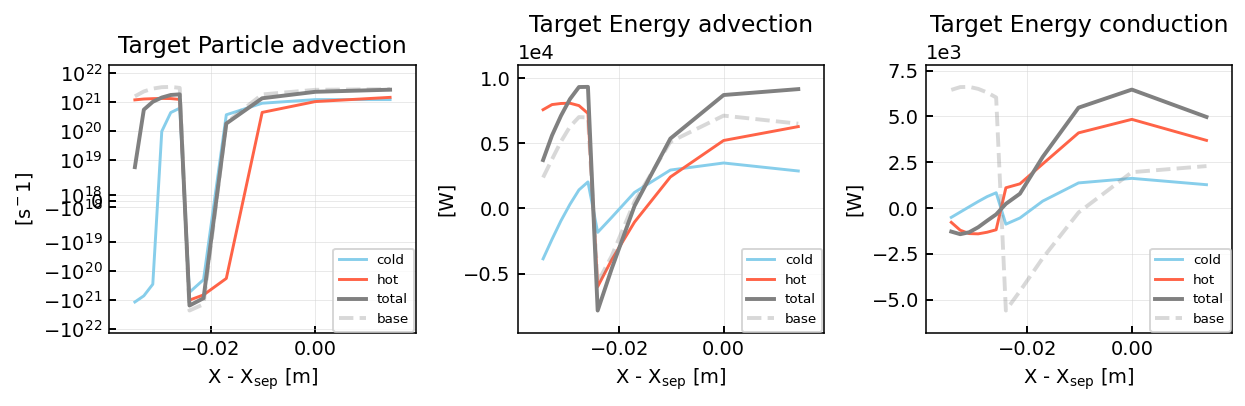

In [33]:
ds = cs[name].ds.isel(t=-1)
reg = ds.hermesm.select_region("outer_lower_target").isel(x = slice(2,-2))
reg2 = cs[basename].ds.hermesm.select_region("outer_lower_target").isel(x = slice(2,-2), t = -1)
comp = compare.regions["outer_lower"]
title = "Target"


fig, axes = plt.subplots(1,3, figsize = (9,3))

x = np.cumsum(reg["dr"]).values
x = x - x[ds.metadata["ixseps1"]]
totkwargs = dict(c = "grey", lw = 2, ls = "-", alpha = 1, label = "total")
basekwargs = dict(c = "grey", lw = 2, marker = "o", ls = "--", ms = 0, alpha = 0.3, markeredgewidth = 0, label = "base")
compkwargs = dict(c = "grey", lw = 0, marker = "x", ms = 1, alpha = 0.3, markeredgewidth = 5, label = "SOLPS")
coldkwargs = dict(label = "cold", c = "skyblue")
hotkwargs = dict(label = "hot", c = "tomato")

ax = axes[0]
ax.set_title(f"{title} Particle advection")
ax.set_yscale("symlog", linthresh = 5e18)
ax.set_ylabel("[$s^-1$]")
ax.plot(x, reg["pf_perp_diff_L_d"], **coldkwargs)
ax.plot(x, reg["pf_perp_diff_L_d*"], **hotkwargs)
ax.plot(x, reg["pf_perp_diff_L_d"]+reg["pf_perp_diff_L_d*"], **totkwargs)
ax.plot(x, reg2["pf_perp_diff_L_d"], **basekwargs)

ax = axes[1]
ax.set_title(f"{title} Energy advection")
ax.set_ylabel("[W]")
ax.plot(x, reg["hf_perp_conv_L_d"], **coldkwargs)
ax.plot(x, reg["hf_perp_conv_L_d*"], **hotkwargs)
ax.plot(x, reg["hf_perp_conv_L_d"]+reg["hf_perp_conv_L_d*"], **totkwargs)
ax.plot(x, reg2["hf_perp_conv_L_d"], **basekwargs)

ax = axes[2]
ax.set_title(f"{title} Energy conduction")
ax.set_ylabel("[W]")
ax.plot(x, reg["hf_perp_diff_L_d"], **coldkwargs)
ax.plot(x, reg["hf_perp_diff_L_d*"], **hotkwargs)
ax.plot(x, (reg["hf_perp_diff_L_d"]+reg["hf_perp_diff_L_d*"]), **totkwargs)
ax.plot(x, reg2["hf_perp_diff_L_d"], **basekwargs)



for ax in axes:
    ax.legend(fontsize = "x-small")
    ax.set_xlabel("X - $X_{sep}$ [m]")

    ax.set_xscale("linear")
    
fig.tight_layout()


## FIeld line

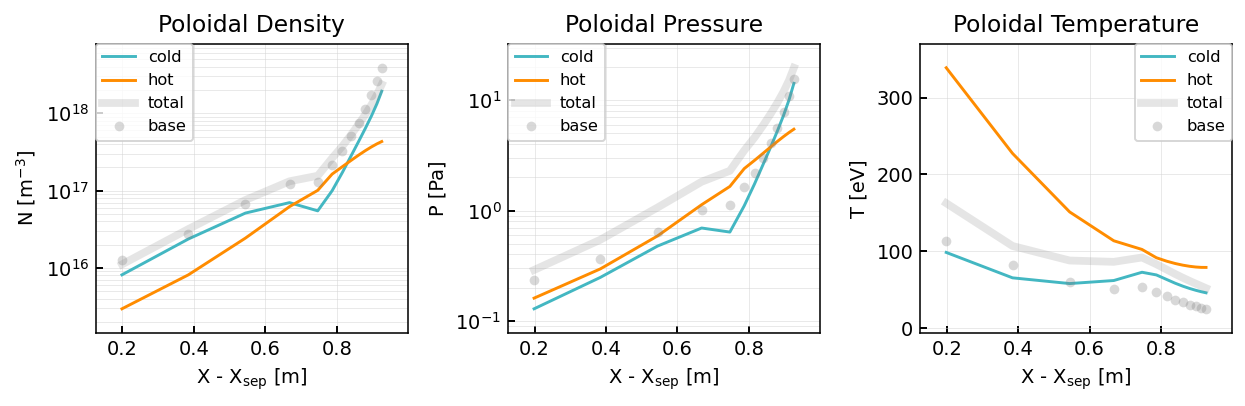

In [42]:
ds = cs[name].ds
reg = ds.hermesm.select_custom_sol_ring(11, region = "outer_lower").isel(theta = slice(None,-2), t = -1).squeeze()
reg2 = cs[basename].ds.hermesm.select_custom_sol_ring(11, region = "outer_lower").isel(theta = slice(None,-2), t = -1).squeeze()
title = "Field line"

fig, axes = plt.subplots(1,3, figsize = (9,3))

x = np.cumsum(reg["dl"]).values

kwargs = dict(marker = "o", ms = 0)
totkwargs = dict(c = "grey", lw = 4, alpha = 0.2)
basekwargs = dict(c = "grey", lw = 0, marker = "o", ms = 5, alpha = 0.3, markeredgewidth = 0)

ax = axes[0]
ax.set_title("Poloidal Density")
ax.set_yscale("log")
ax.set_ylabel("N [$m^{-3}$]")
ax.plot(x, reg["Nd"], label = "cold", **kwargs)
ax.plot(x, reg["Nd*"], label = "hot", c = "darkorange", **kwargs)
ax.plot(x, reg["Nd"]+reg["Nd*"], label = "total", **totkwargs)
ax.plot(x, reg2["Nd"], label = "base", **basekwargs)

ax = axes[1]
ax.set_title("Poloidal Pressure")
ax.set_yscale("log")
ax.set_ylabel("P [Pa]")
ax.plot(x, reg["Pd"], label = "cold", **kwargs)
ax.plot(x, reg["Pd*"], label = "hot", c = "darkorange", **kwargs)
ax.plot(x, reg["Pd"]+reg["Pd*"], label = "total", **totkwargs)
ax.plot(x, reg2["Pd"], label = "base", **basekwargs)

ax = axes[2]
ax.set_title("Poloidal Temperature")
ax.set_ylabel("T [eV]")
ax.plot(x, reg["Td"], label = "cold", **kwargs)
ax.plot(x, reg["Td*"], label = "hot", c = "darkorange", **kwargs)
ax.plot(x, (reg["Pd"]+reg["Pd*"])/(reg["Nd*"]+reg["Nd"])/constants("q_e"), label = "total", **totkwargs)
ax.plot(x, reg2["Td"], label = "base", **basekwargs)


for ax in axes:
    ax.legend(fontsize = "small")
    ax.set_xlabel("X - $X_{sep}$ [m]")

    ax.set_xscale("linear")
    
fig.tight_layout()


# 2D plots

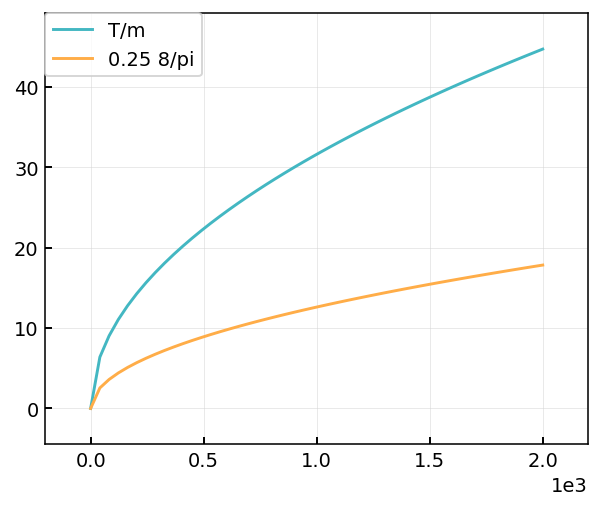

In [46]:
T = np.linspace(0,2000)
y1 = np.sqrt(T)
y2 = 0.25 * np.sqrt(8 * T/ np.pi)

fig, ax = plt.subplots()
ax.plot(T, y1, label = "T/m")
ax.plot(T, y2, label = "0.25 8/pi")
ax.legend()
# ax.plot(T, y2/y1)

## Hot neutral diags

In [83]:
cs.keys()

dict_keys(['base_noAFN', 'base_AFN', 'base_AFN_nocondlim', 'hotneut', 'hotneut_AFN'])

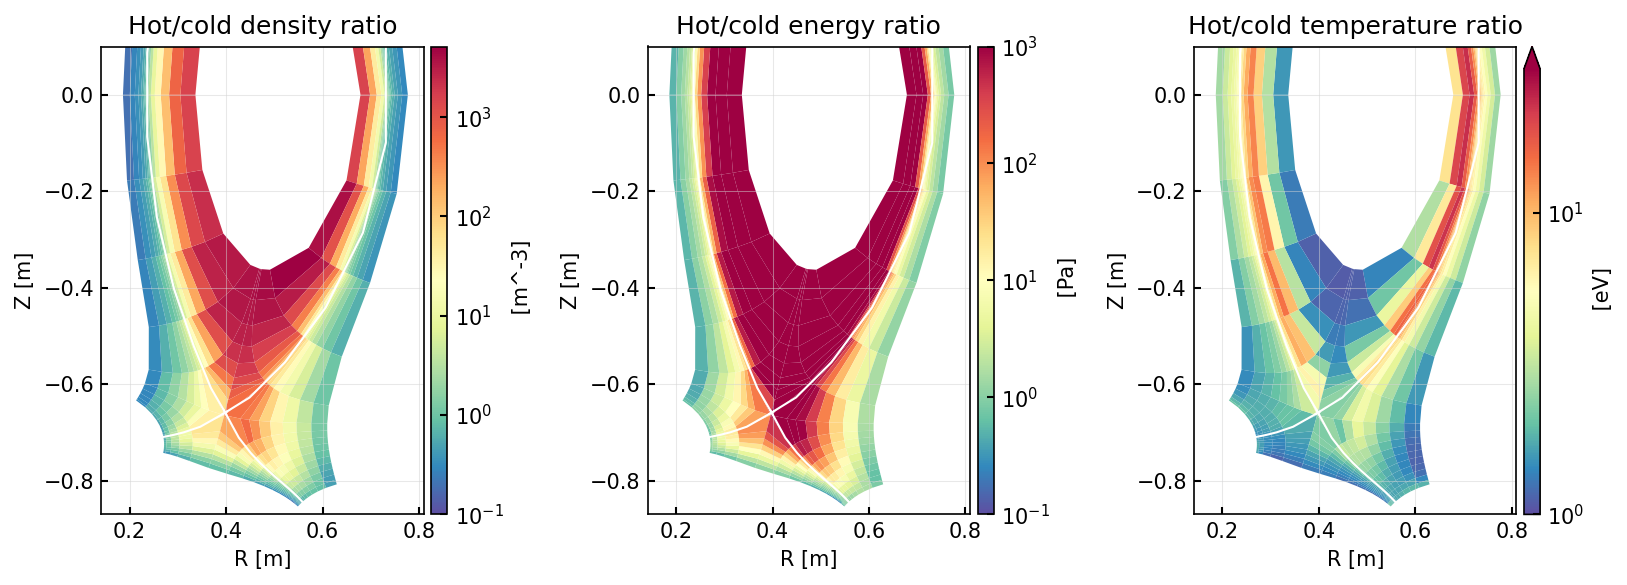

In [31]:
fig, axes = plt.subplots(1,3, dpi = 150, figsize = (11,4))

ds = cs["hotneut"].ds
if "t" in ds.dims: ds = ds.isel(t=-1)
sepkwargs = dict(linewidth = 1, color = "white", linestyle = "-")
(ds["Nd*"] / ds["Nd"]).hermesm.clean_guards().bout.polygon(ax = axes[0], cmap = "Spectral_r", antialias = True, 
                                                            vmin = 0.1, vmax = None, logscale = True, 
                                                            separatrix_kwargs = sepkwargs, targets = False)

(ds["Pd*"] / ds["Pd"]).hermesm.clean_guards().bout.polygon(ax = axes[1], cmap = "Spectral_r", antialias = True,
                                                           vmin = 0.1, vmax = 1000, logscale = True, 
                                                           separatrix_kwargs = sepkwargs, targets = False)

(ds["Td*"] / ds["Td"]).hermesm.clean_guards().bout.polygon(ax = axes[2], cmap = "Spectral_r", antialias = True, 
                                                            vmin = 1, vmax = 30, extend = "max", logscale = True, 
                                                            separatrix_kwargs = sepkwargs, targets = False)

axes[0].set_title("Hot/cold density ratio")
axes[1].set_title("Hot/cold energy ratio")
axes[2].set_title("Hot/cold temperature ratio")

for ax in axes:
    ax.set_ylim(-0.87,0.1)
    
fig.tight_layout()

## Fields

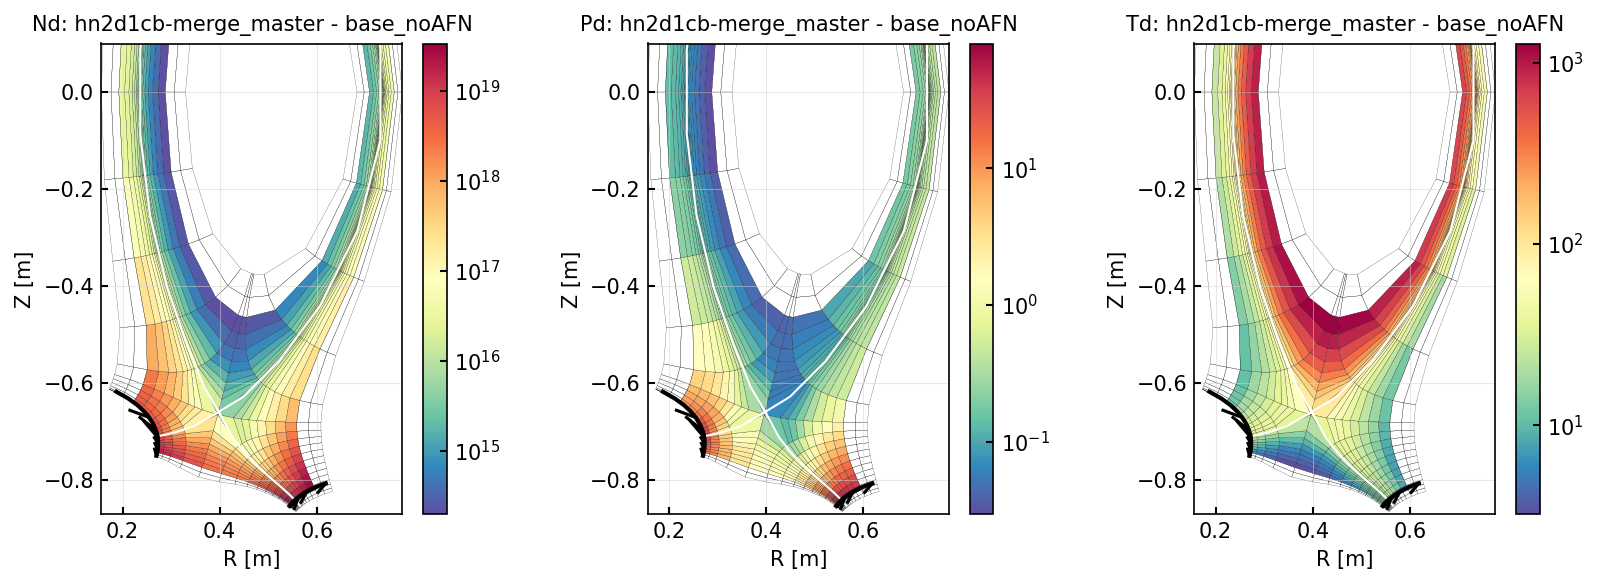

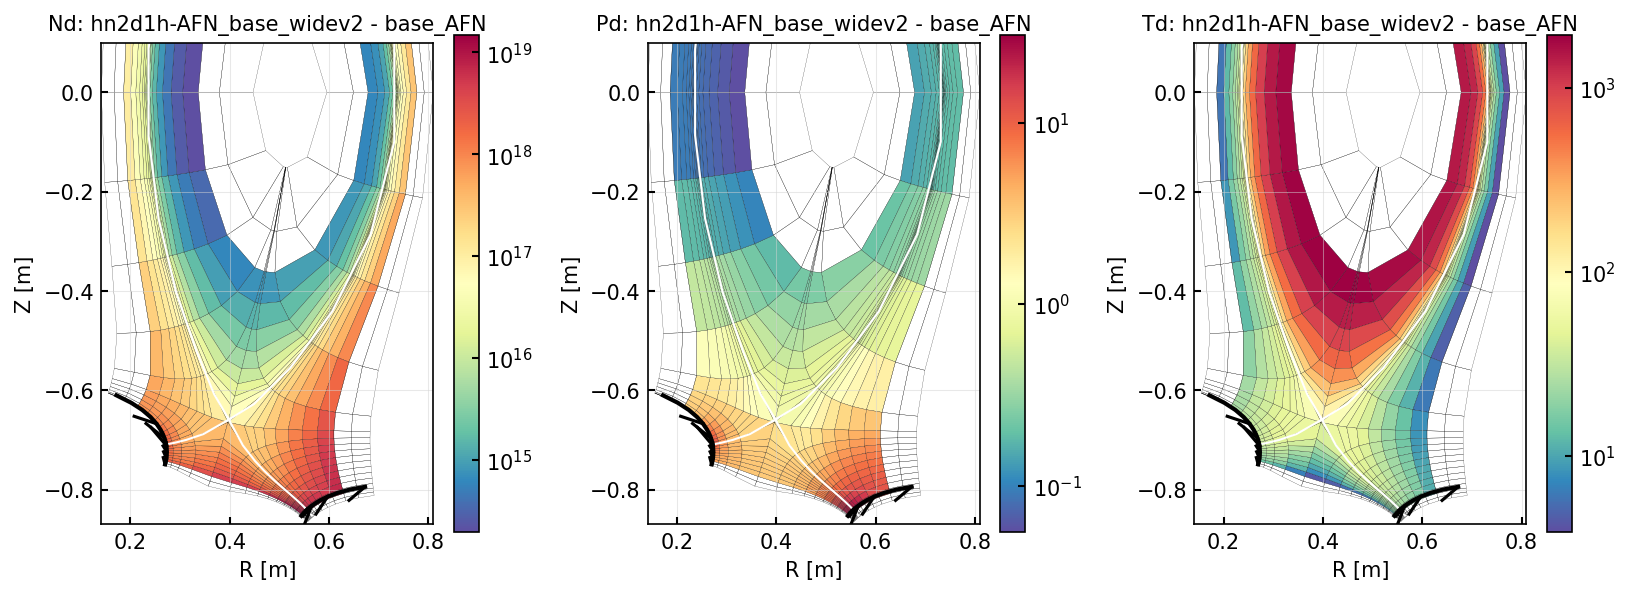

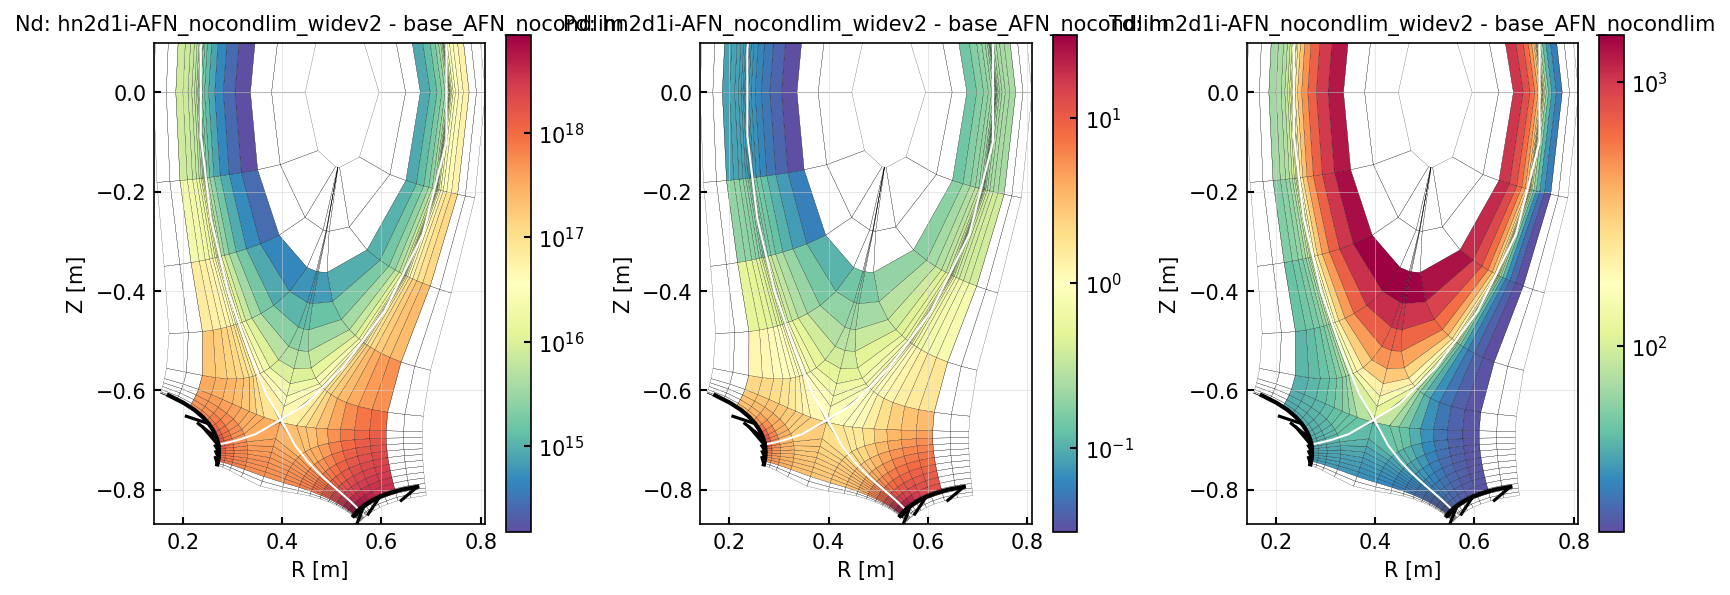

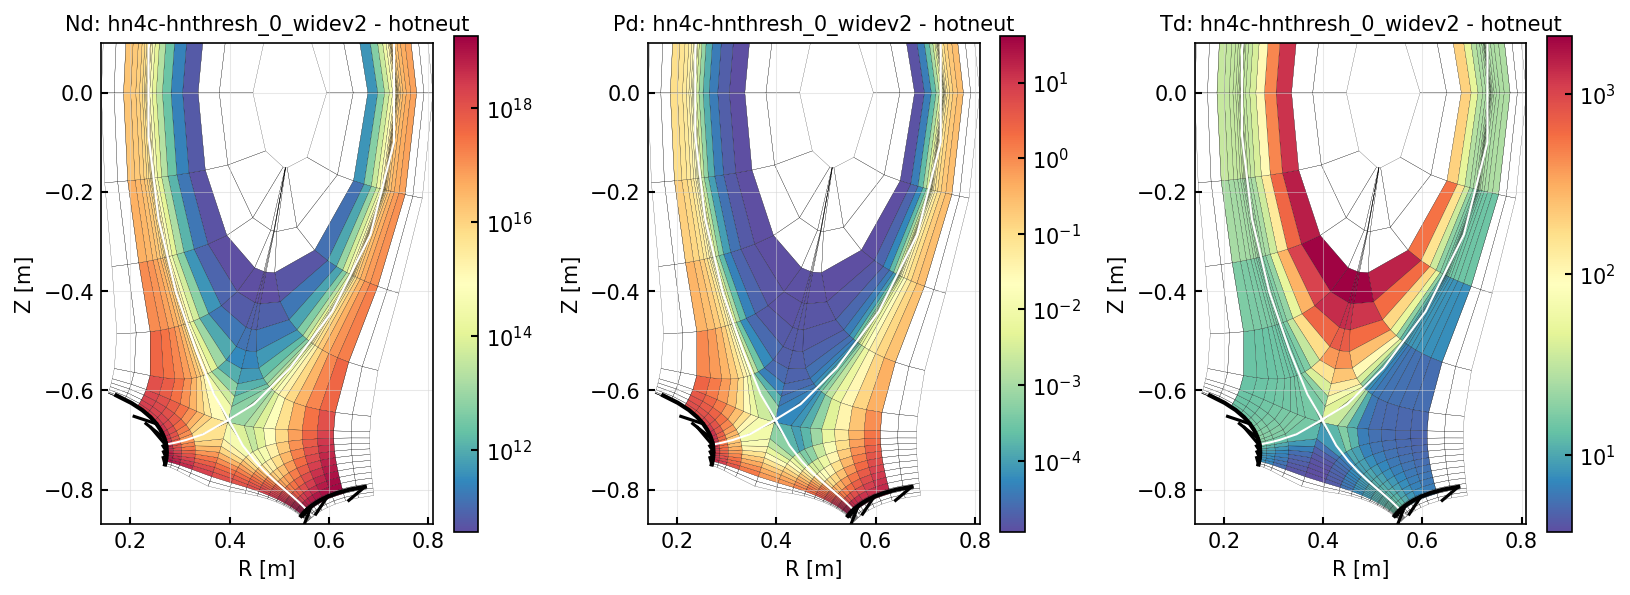

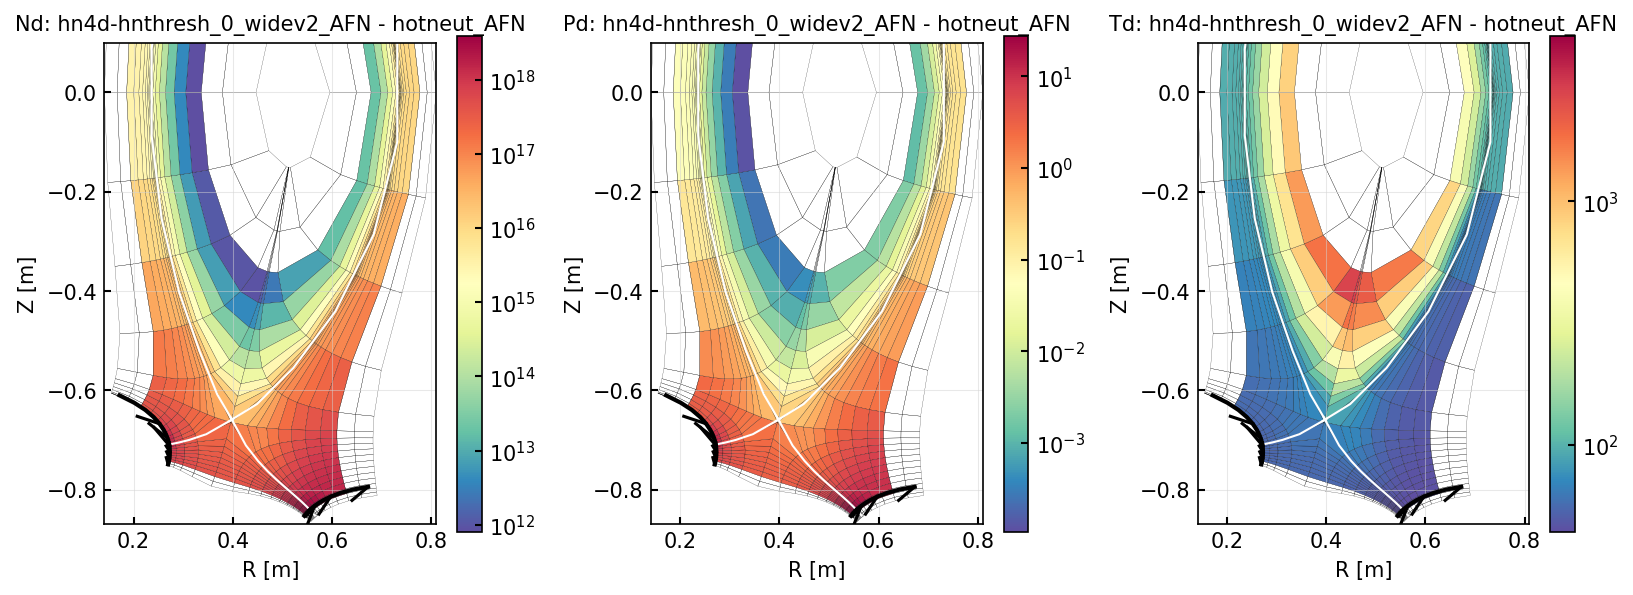

In [86]:
clean_guards = True

xlims = (None, None)
ylims = (-0.87,0.1)

# params = ["Te", "Td+", "Td"]
params = ["Nd", "Pd", "Td"]
sepkwargs = dict(linewidth = 1, color = "white", linestyle = "-")

for entry in toload:
    case = entry["name"]
    fig, axes = plt.subplots(1,3, figsize = (11,4), dpi = 150)
    newds = cs[case].ds.isel(t=-1)
    
    ax = axes[0]
    param = params[0]
    data = (newds[param])
    if clean_guards:
        data = data.hermesm.clean_guards()
    data.bout.polygon(ax, cmap = "Spectral_r", 
                                        # vmax = 25, vmin = 300, 
                                        antialias = True, linewidth = 0.1, logscale = True, separatrix_kwargs = sepkwargs)
    ax.set_ylim(ylims)
    ax.set_xlim(xlims)
    ax.set_title(f"{param}: {entry['id']} - {entry['name']}", fontsize = "medium")
    
    
    ax = axes[1]
    param = params[1]
    data = (newds[param])
    if clean_guards:
        data = data.hermesm.clean_guards()
    data.bout.polygon(ax, cmap = "Spectral_r", 
                                        # vmax = 25, vmin = 300, 
                                        antialias = True, linewidth = 0.1, logscale = True, separatrix_kwargs = sepkwargs)
    ax.set_ylim(ylims)
    ax.set_xlim(xlims)
    ax.set_title(f"{param}: {entry['id']} - {entry['name']}", fontsize = "medium")
    
    
    ax = axes[2]
    param = params[2]
    data = (newds[param])
    if clean_guards:
        data = data.hermesm.clean_guards()
    data.bout.polygon(ax, cmap = "Spectral_r", 
                                        # vmax = 25, vmin = 300, 
                                        antialias = True, linewidth = 0.1, logscale = True, separatrix_kwargs = sepkwargs)
    ax.set_ylim(ylims)
    ax.set_xlim(xlims)
    ax.set_title(f"{param}: {entry['id']} - {entry['name']}", fontsize = "medium")
    
    fig.tight_layout()


# Rec heating analysis

In [89]:
cs.keys()

dict_keys(['base_noAFN', 'base_AFN', 'base_AFN_nocondlim', 'hotneut', 'hotneut_AFN'])

In [61]:
izrate = np.array([
    [-32.4802533034, -0.05440669186583, 0.09048888225109, -0.04054078993576,
     0.008976513750477, -0.001060334011186, 6.846238436472e-05, -2.242955329604e-06,
     2.890437688072e-08],
    [14.2533239151, -0.0359434716076, -0.02014729121556, 0.0103977361573,
     -0.001771792153042, 0.0001237467264294, -3.130184159149e-06, -3.051994601527e-08,
     1.888148175469e-09],
    [-6.632235026785, 0.09255558353174, -0.005580210154625, -0.005902218748238,
     0.001295609806553, -0.0001056721622588, 4.646310029498e-06, -1.479612391848e-07,
     2.85225125832e-09],
    [2.059544135448, -0.07562462086943, 0.01519595967433, 0.0005803498098354,
     -0.0003527285012725, 3.201533740322e-05, -1.835196889733e-06, 9.474014343303e-08,
     -2.342505583774e-09],
    [-0.442537033141, 0.02882634019199, -0.00728577148505, 0.0004643389885987,
     1.145700685235e-06, 8.493662724988e-07, -1.001032516512e-08, -1.476839184318e-08,
     6.047700368169e-10],
    [0.06309381861496, -0.00578868653578, 0.00150738295525, -0.0001201550548662,
     6.574487543511e-06, -9.678782818849e-07, 5.176265845225e-08, 1.29155167686e-09,
     -9.685157340473e-11],
    [-0.005620091829261, 0.000632910556804, -0.0001527777697951, 8.270124691336e-06,
     3.224101773605e-08, 4.377402649057e-08, -2.622921686955e-09, -2.259663431436e-10,
     1.161438990709e-11],
    [0.0002812016578355, -3.564132950345e-05, 7.222726811078e-06, 1.433018694347e-07,
     -1.097431215601e-07, 7.789031791949e-09, -4.197728680251e-10, 3.032260338723e-11,
     -8.911076930014e-13],
    [-6.011143453374e-06, 8.089651265488e-07, -1.186212683668e-07, -2.381080756307e-08,
     6.271173694534e-09, -5.48301024493e-10, 3.064611702159e-11, -1.355903284487e-12,
     2.935080031599e-14]
    ])

recrate = np.array([
    [-28.58858570847, 0.02068671746773, -0.007868331504755, 0.003843362133859,
     -0.0007411492158905, 9.273687892997e-05, -7.063529824805e-06, 3.026539277057e-07,
     -5.373940838104e-09],
    [-0.7676413320499, 0.0127800603259, -0.01870326896978, 0.00382855504889,
     -0.0003627770385335, 4.401007253801e-07, 1.932701779173e-06, -1.176872895577e-07,
     2.215851843121e-09],
    [0.002823851790251, -0.001907812518731, 0.01121251125171, -0.003711328186517,
     0.0006617485083301, -6.860774445002e-05, 4.508046989099e-06, -1.723423509284e-07,
     2.805361431741e-09],
    [-0.01062884273731, -0.01010719783828, 0.004208412930611, -0.00100574441054,
     0.0001013652422369, -2.044691594727e-06, -4.431181498017e-07, 3.457903389784e-08,
     -7.374639775683e-10],
    [0.001582701550903, 0.002794099401979, -0.002024796037098, 0.0006250304936976,
     -9.224891301052e-05, 7.546853961575e-06, -3.682709551169e-07, 1.035928615391e-08,
     -1.325312585168e-10],
    [-0.0001938012790522, 0.0002148453735781, 3.393285358049e-05, -3.746423753955e-05,
     7.509176112468e-06, -8.688365258514e-07, 7.144767938783e-08, -3.367897014044e-09,
     6.250111099227e-11],
    [6.041794354114e-06, -0.0001421502819671, 6.14387907608e-05, -1.232549226121e-05,
     1.394562183496e-06, -6.434833988001e-08, -2.746804724917e-09, 3.564291012995e-10,
     -8.55170819761e-12],
    [1.742316850715e-06, 1.595051038326e-05, -7.858419208668e-06, 1.774935420144e-06,
     -2.187584251561e-07, 1.327090702659e-08, -1.386720240985e-10, -1.946206688519e-11,
     5.745422385081e-13],
    [-1.384927774988e-07, -5.664673433879e-07, 2.886857762387e-07, -6.591743182569e-08,
     8.008790343319e-09, -4.805837071646e-10, 6.459706573699e-12, 5.510729582791e-13,
     -1.680871303639e-14]
])

from sd1d.analysis import AMJUEL





*****************************
Excel saves precision as it appears, not as what the number has.......
*****************************


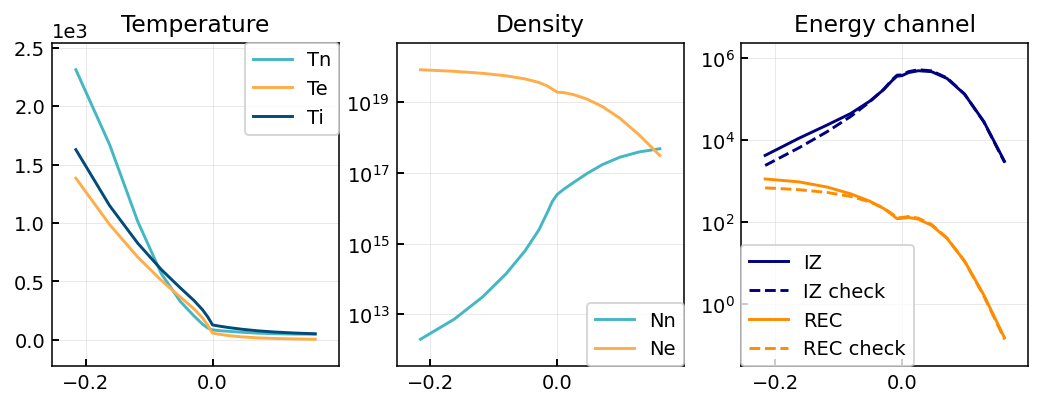

In [62]:
ds = cs["hotneut_AFN"].ds.isel(t=-1)

reg = ds.isel(x = slice(2,-2), theta = 45)   # Radial slice above X-point
# reg = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))           # OMP

fig, axes = plt.subplots(1,3, figsize = (9,3))

x = reg["dr"].cumsum()
x -= x[ds.metadata["ixseps1"] - ds.metadata["MXG"]]

Te = reg["Te"].values
Ne = reg["Ne"].values

amj = AMJUEL()
Krec = amj.amjuel_2d("rec", Te, Ne, data = recrate)
Kiz = amj.amjuel_2d("rec", Te, Ne, data = izrate)

ax = axes[0]
ax.set_title("Temperature")
ax.plot(x, reg["Td"], label = "Tn")
ax.plot(x, reg["Te"], label = "Te")
ax.plot(x, reg["Td+"], label = "Ti")
ax.legend()

# ax = axes[0,1]
# ax.set_title("Density channel")
# ax.set_yscale("log")
# ax.plot(x, reg["Sdd+_iz"], c = "navy", label = "IZ")
# ax.plot(x, Kiz * reg["Ne"] * reg["Nd"], c = "navy", ls = "--", label = "IZ check")
# ax.plot(x, reg["Sd+_rec"]*-1, c = "darkorange", label = "REC")
# ax.plot(x, Krec * reg["Ne"]**2, c = "darkorange", ls = "--", label = "REC check")
# ax.legend()

ax = axes[1]
ax.set_title("Density")
ax.set_yscale("log")
ax.plot(x, reg["Nd"], label = "Nn")
ax.plot(x, reg["Ne"], label = "Ne")
ax.legend()

ax = axes[2]
ax.set_title("Energy channel")
ax.set_yscale("log")
ax.plot(x, reg["Edd+_iz"], c = "navy", label = "IZ")
ax.plot(x, Kiz * reg["Ne"] * reg["Nd"] * reg["Td"] * (3/2) * constants("q_e"), c = "navy", ls = "--", label = "IZ check")
ax.plot(x, reg["Ed+_rec"]*-1, c = "darkorange", label = "REC")
ax.plot(x, Krec * reg["Ne"]**2 * reg["Td+"] * (3/2) * constants("q_e"), c = "darkorange", ls = "--", label = "REC check")
ax.legend()

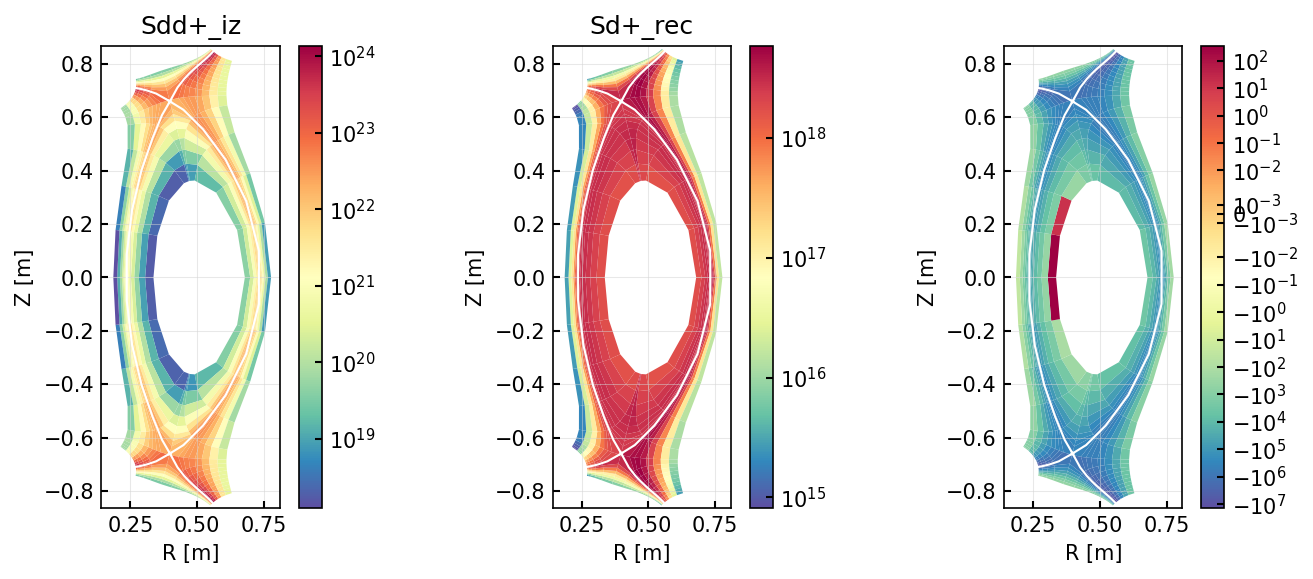

In [60]:
ds = cs["hotneut_AFN"].ds.isel(t=-1)
# dSrcTot = ds["Ed_wall_refl"] + ds["Edd*_wall_refl"] + ds["Edd+_cxt"] + ds["Edd+_iz"]*-1 + ds["Ed+_rec"] * -1
dSrcTot = ds["Edd+_iz"]*-1 + ds["Ed+_rec"] * -1

fig, axes = plt.subplots(1,3, dpi = 150, figsize = (11,4))

(ds["Sdd+_iz"]).hermesm.clean_guards().bout.polygon(ax = axes[0], cmap = "Spectral_r", antialias = True, 
                                                            vmin = None, vmax = None, 
                                                            logscale = True, 
                                                            separatrix_kwargs = sepkwargs, targets = False)

(ds["Sd+_rec"] * -1).hermesm.clean_guards().bout.polygon(ax = axes[1], cmap = "Spectral_r", antialias = True, 
                                                            vmin = None, vmax = None, 
                                                            logscale = True, 
                                                            separatrix_kwargs = sepkwargs, targets = False)

(dSrcTot).hermesm.clean_guards().bout.polygon(ax = axes[2], cmap = "Spectral_r", antialias = True, 
                                                            vmin = None, vmax = None, 
                                                            logscale = True, 
                                                            separatrix_kwargs = sepkwargs, targets = False)

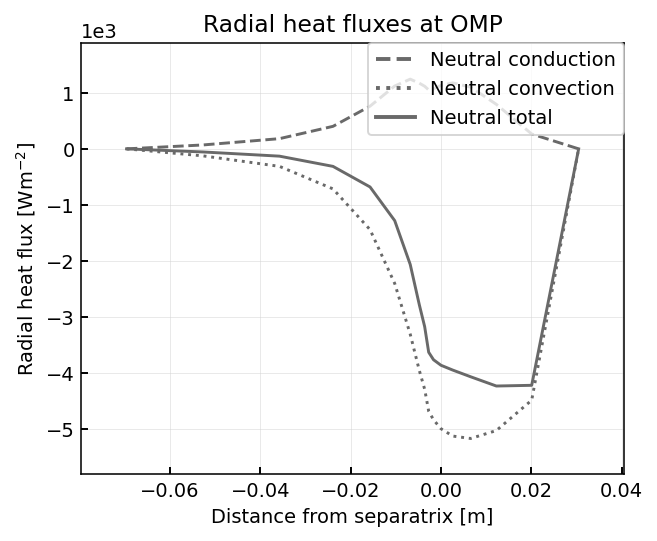

In [118]:
plot_perp_heat_fluxes(ds, loc = "omp", neutrals_only = True)

In [65]:
cs.keys()

dict_keys(['base_noAFN', 'base_AFN', 'base_AFN_nocondlim', 'hotneut', 'hotneut_AFN'])

In [70]:
calculate_neutral_heat_balance(cs["base_AFN_nocondlim"].ds.isel(t=-1))

d   d*     total
target_refl    -0.051540  NaN -0.051540
inner_sol_refl -0.022567  NaN -0.022567
outer_sol_refl -0.167568  NaN -0.167568
pfr_refl       -0.159907  NaN -0.159907
target_trefl         NaN  NaN  0.000000
wall_trefl           NaN  NaN  0.000000
target_recycle  0.374708  NaN  0.374708
wall_recycle    0.000123  NaN  0.000123
core_escape    -0.050507  NaN -0.050507
sol_escape     -0.080425  NaN -0.080425
iz             -0.806240  NaN -0.806240
rec             0.000236  NaN  0.000236
cx              0.847155  NaN  0.847155
cxt                  NaN  NaN  0.000000
src             0.000865  NaN  0.000865
TOTAL BALANCE  -0.115668  0.0 -0.115668

In [105]:
mins.min()

AttributeError: 'list' object has no attribute 'min'

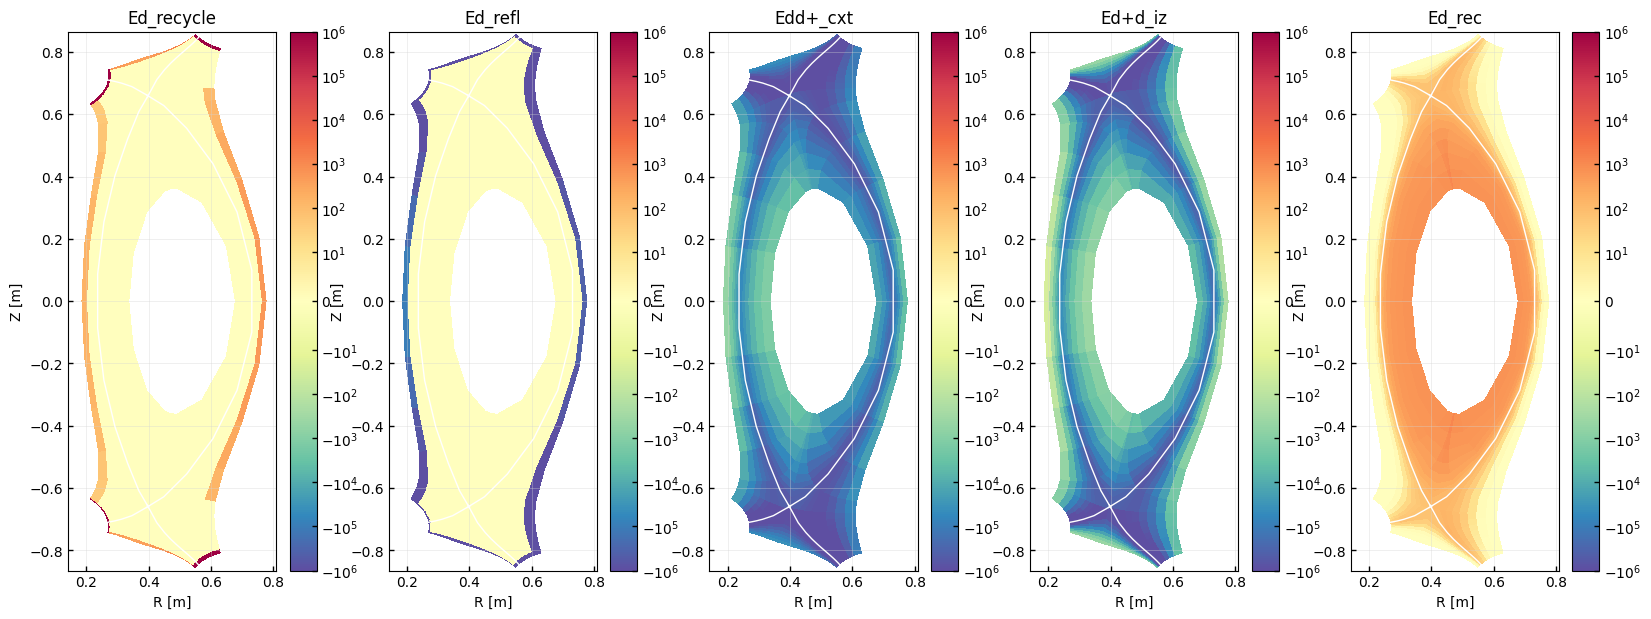

In [72]:

          
ds["Ed_recycle"] = ds["Ed_wall_recycle"] + ds["Ed_target_recycle"]
ds["Ed_refl"] = ds["Ed_wall_refl"] + ds["Ed_target_refl"]
ds["Ed+d_iz"] = ds["Edd+_iz"] *-1
ds["Ed_rec"] = ds["Ed+_rec"] * -1

params = ["Ed_recycle", "Ed_refl", "Edd+_cxt", "Ed+d_iz", "Ed_rec"]

mins = []
maxes = []

for param in params:
    mins.append(np.nanmin(ds[param].hermesm.clean_guards().values))
    maxes.append(np.nanmax(ds[param].hermesm.clean_guards().values))
    
min = np.nanmin(mins)
max = np.nanmax(maxes)

min = -1e6
max = 1e6

fig, axes = plt.subplots(1, len(params), figsize = (4*len(params), 7), dpi = 100)

for i, param in enumerate(params):
    ds[param].hermesm.clean_guards().bout.polygon(ax = axes[i], 
                                                  vmin = min, vmax = max, 
                                                  logscale = True,
                                                  cmap = "Spectral_r", separatrix_kwargs = sepkwargs, targets = False)
    

# dSrcTot = ds["Ed_wall_refl"] + ds["Edd*_wall_refl"] + ds["Edd+_cxt"] + ds["Edd+_iz"]*-1 + ds["Ed+_rec"] * -1

# Floor check

In [63]:
# ds = cs["newalldisabled_lopnfloor"].ds.isel(t=-1)
for case in cs:
    ds = cs[case].ds.isel(t=-1)
    # cmap = mpl.colors.LinearSegmentedColormap.from_list("custom", ["darkorange", "white", "navy"], N=3)
    cmap = "PuOr"

    floors = ds.hermesm.get_floors()
    nn_floor_si = floors["nn_floor_si"]
    pn_floor_si = floors["pn_floor_si"]
    
    nn_breached = (ds["Nd"].values < floors["nn_floor_si"]).any()
    pn_breached = (ds["Pd"].values < floors["pn_floor_si"]).any()
    
    print(f"{case}: Nn floor breached: {nn_breached}, Pn floor breached: {pn_breached}")
    


base_noAFN: Nn floor breached: False, Pn floor breached: False
base_AFN: Nn floor breached: False, Pn floor breached: False
base_AFN_nocondlim: Nn floor breached: False, Pn floor breached: False
hotneut: Nn floor breached: False, Pn floor breached: False
hotneut_AFN: Nn floor breached: False, Pn floor breached: False
